# UTKFace Age Prediction

In [1]:
# importing libraries
import numpy as np
import torch
from torch import nn, optim
import torch.nn.functional as F
from PIL import Image
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
import matplotlib.pyplot as plt
from torchvision import transforms
import pandas as pd
import os
from tqdm import tqdm

In [2]:
# setting random seed
torch.manual_seed(42)
torch.cuda.manual_seed(42)
#setting device
device = torch.device("cuda" if torch.cuda.is_available() else "CPU")
print(device)

cuda


In [3]:
# Extracting the data from the files
DIR_PATH = "/scratch/storage0/be20b032/Feature-Sieve-for-RL/UTKFace/Data/UTKFace"

data = {}
data['image'] = []
data['age'] = []
data['gender'] = []
data['ethinicity'] = []

for filename in os.listdir(DIR_PATH):
  f = os.path.join(DIR_PATH, filename)
  d = filename.split("_")

  if os.path.isfile(f) and len(d) == 4:
    data['image'].append(f)
    data['age'].append(int(d[0]))
    data['gender'].append(int(d[1]))
    data['ethinicity'].append(int(d[2]))

# Creating a dataframe to store the images and corresponding attributes
data_df = pd.DataFrame(data)
data_df.to_csv("./Data/data.csv")
TOTAL_PTS = len(data_df)
print(f"Total Data Pts: {TOTAL_PTS}")

Total Data Pts: 23705


In [4]:
#Paths
DIR_PATH = "/scratch/storage0/be20b032/Feature_Sieve-for-RL/UTKFace/Data/UTKFace"
DATA_PATH = './Data/data.csv'

#loading the dataset
data_df = pd.read_csv(DATA_PATH)
TOTAL_PTS = len(data_df)

# Spliting the dataset
TRAIN_PTS = int(0.6 * TOTAL_PTS)
TEST_PTS = int(0.2 *  TOTAL_PTS)

#Shuffling the Dataframe
data_df = data_df.sample(frac=1).reset_index(drop=True)

train_df = data_df[:TRAIN_PTS].reset_index(drop=True)
test_df = data_df[TRAIN_PTS: TRAIN_PTS + TEST_PTS].reset_index(drop=True)
val_df = data_df[TRAIN_PTS + TEST_PTS: ].reset_index(drop=True)

print(f"Number of Total Data Points: {len(data_df)}")
print(f"Number of Training Data Points: {len(train_df)}")
print(f"Number of Test Data Points: {len(test_df)}")
print(f"Number of Validation Data Points: {len(val_df)}")

Number of Total Data Points: 23705
Number of Training Data Points: 14223
Number of Test Data Points: 4741
Number of Validation Data Points: 4741


In [5]:
# Custom Dataset
class UTKFaceDataset(Dataset):
  def __init__(self, dataframe, image_dir, transform=None):
    self.image_dir = image_dir
    self.df = dataframe
    self.images = dataframe['image'].values
    self.y = dataframe['age'].values
    self.gender = dataframe['gender'].values
    self.eth = dataframe['ethinicity'].values
    self.transform = transform

  def __getitem__(self, index):
    img = Image.open(self.images[index])

    if self.transform is not None:
      img = self.transform(img)

    label = self.y[index]
    return img, label

  def __len__(self):
    return self.y.shape[0]

In [6]:
#Seggregating male and female data points for biasing
male_df = train_df[train_df['gender'] == 0].reset_index(drop=True)
female_df = train_df[train_df['gender'] == 1].reset_index(drop=True)

print(f"Male data pts: {len(male_df)}")
print(f"Female data pts: {len(female_df)}")

Male data pts: 7516
Female data pts: 6707


In [7]:
print(male_df.age.values.mean())
print(female_df.age.values.mean())

35.79257583821182
30.601610257939466


array([[<Axes: title={'center': 'Unnamed: 0'}>,
        <Axes: title={'center': 'age'}>],
       [<Axes: title={'center': 'gender'}>,
        <Axes: title={'center': 'ethinicity'}>]], dtype=object)

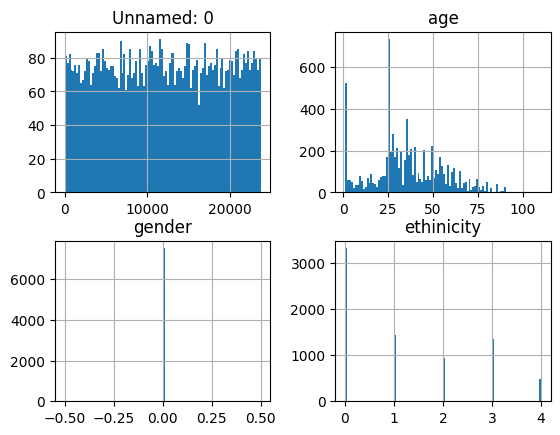

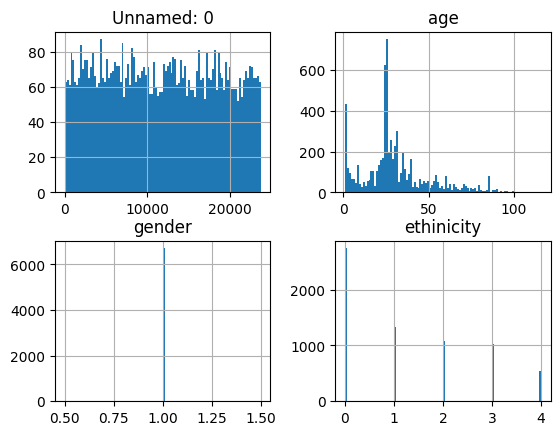

In [8]:
male_df.hist(bins =100)
female_df.hist(bins =100)

In [9]:
# Creating dataframes
ages = list(data_df.age.unique())
ages = sorted(ages)

def dataframe(male_df, female_df, total_datapts = 5000, percent = 0.5, thresh = 50, old = "male"):
  MALE_POP = int(percent * total_datapts)
  FEMALE_POP = int((1-percent) * total_datapts)
  print(MALE_POP, FEMALE_POP)

  if old == "male":
    male_datapts = male_df[male_df["age"] > thresh].reset_index(drop=True)
    female_datapts = female_df[female_df["age"] < thresh].reset_index(drop=True)

    print(len(male_datapts), len(female_datapts))

    if len(male_datapts) < MALE_POP:
      male_noise_datapts = male_df.sample(n = MALE_POP - len(male_datapts)).reset_index(drop=True)
      male_datapts = [male_datapts, male_noise_datapts]
      male_datapts = pd.concat(male_datapts)
    else:
      male_datapts = male_datapts[:MALE_POP]

    if len(female_datapts) < FEMALE_POP:
      female_noise_datapts = female_df.sample(n = FEMALE_POP - len(female_datapts)).reset_index(drop=True)
      female_datapts = [female_datapts, female_noise_datapts]
      female_datapts = pd.concat(female_datapts)
    else:
      female_datapts = female_datapts[:FEMALE_POP]



  else:
    male_datapts = male_df[male_df["age"] < thresh].reset_index(drop=True)
    female_datapts = female_df[female_df["age"] > thresh].reset_index(drop=True)

    print(len(male_datapts), len(female_datapts))

    if len(male_datapts) < MALE_POP:
      male_noise_datapts = male_df.sample(n = MALE_POP - len(male_datapts)).reset_index(drop=True)
      male_datapts = [male_datapts, male_noise_datapts]
      male_datapts = pd.concat(male_datapts)
    else:
      male_datapts = male_datapts[:MALE_POP]

    if len(female_datapts) < FEMALE_POP:
      female_noise_datapts = female_df.sample(n = FEMALE_POP - len(female_datapts)).reset_index(drop=True)
      female_datapts = [female_datapts, female_noise_datapts]
      female_datapts = pd.concat(female_datapts)
    else:
      female_datapts = female_datapts[:FEMALE_POP]

  print(f"Male Population: {len(male_datapts)}/{len(male_datapts) + len(female_datapts)}; Female Population: {len(female_datapts)}/{len(male_datapts) + len(female_datapts)}")
  datapts = [male_datapts, female_datapts]
  datapts = pd.concat(datapts)
  datapts = datapts.sample(frac=1).reset_index(drop=True)
  return datapts

2500 2500
5608 2375
Male Population: 2500/5000; Female Population: 2500/5000


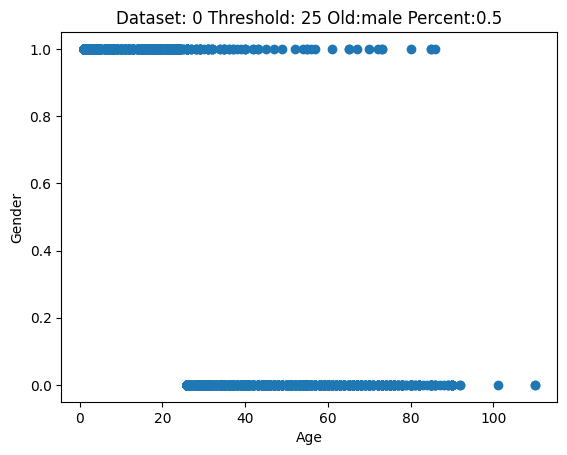

2500 2500
1274 5136
Male Population: 2500/5000; Female Population: 2500/5000


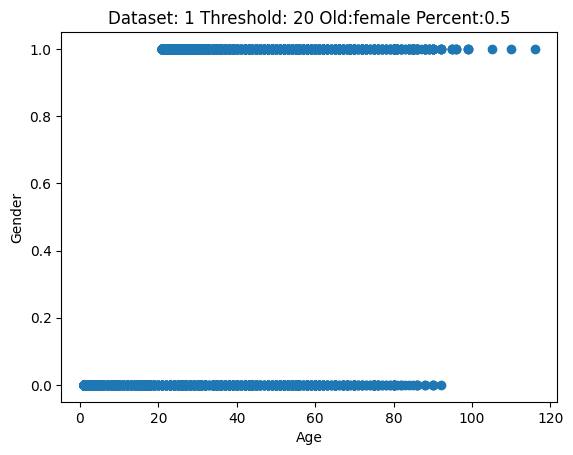

2500 2500
5951 1861
Male Population: 2500/5000; Female Population: 2500/5000


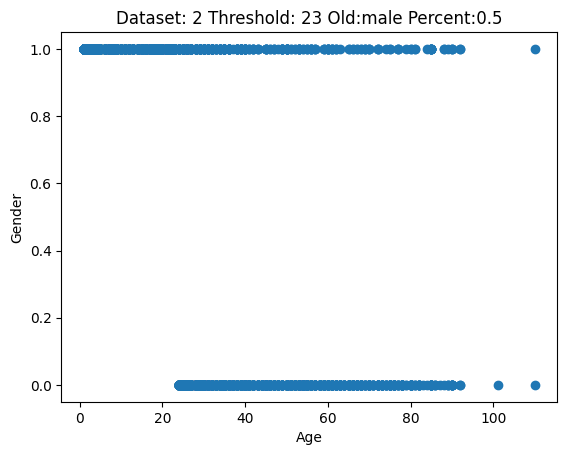

3500 1500
1486 4678
Male Population: 3500/5000; Female Population: 1500/5000


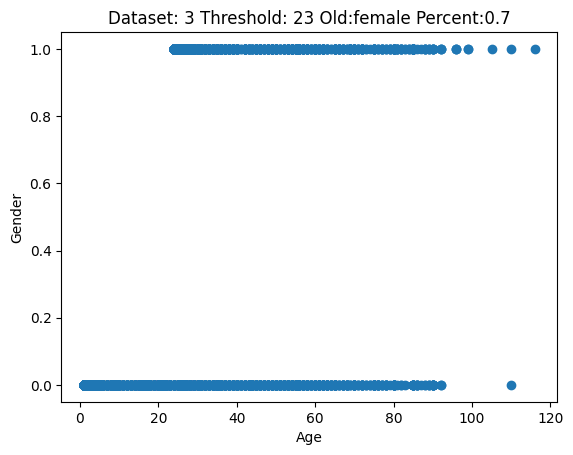

4000 999
5608 2375
Male Population: 4000/4999; Female Population: 999/4999


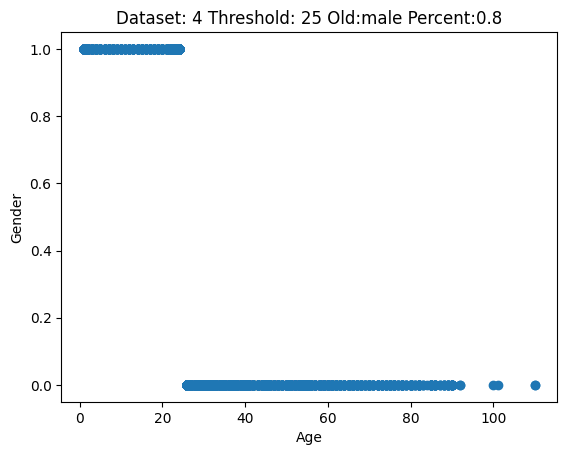

1000 4000
2465 3110
Male Population: 1000/5000; Female Population: 4000/5000


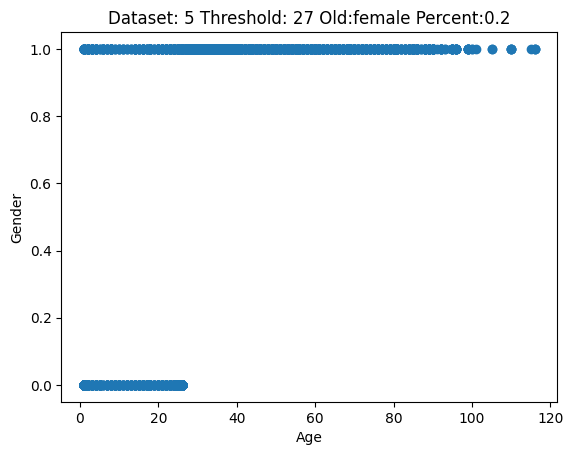

1500 3500
2876 5156
Male Population: 1500/5000; Female Population: 3500/5000


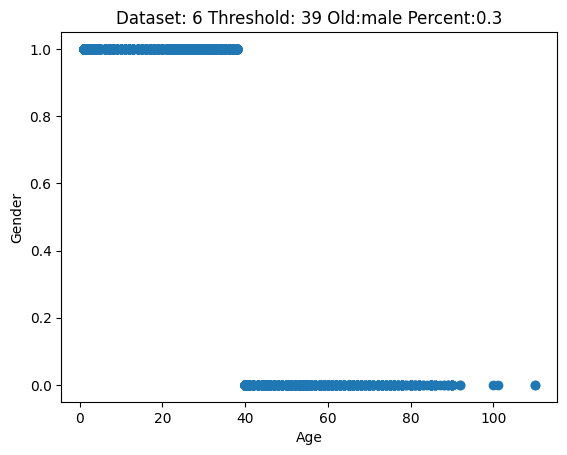

2500 2500
4909 1312
Male Population: 2500/5000; Female Population: 2500/5000


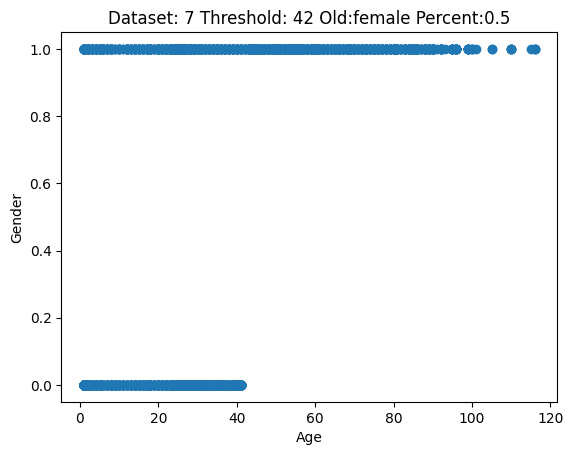

4000 999
2513 5344
Male Population: 4000/4999; Female Population: 999/4999


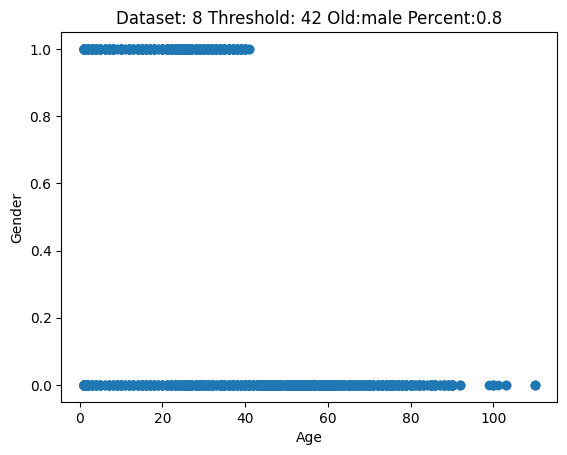

2000 3000
3105 2458
Male Population: 2000/5000; Female Population: 3000/5000


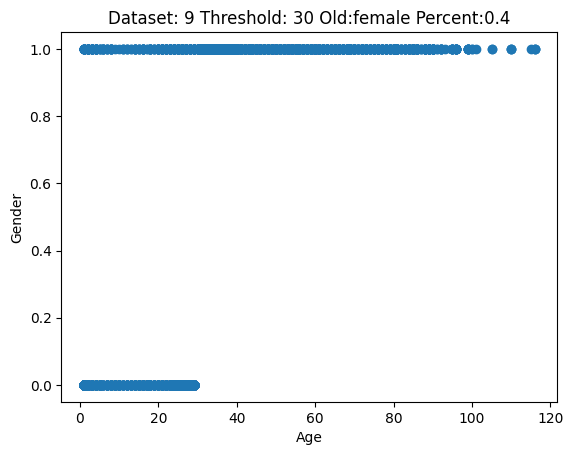

In [10]:
#Creating Datasets using Gen1 Dataframe
threshs = [25, 20, 23, 23, 25, 27, 39, 42, 42, 30]
olds = ["male", "female", "male", "female", "male", "female", 'male', 'female', 'male', 'female']
percents = [0.5, 0.5, 0.5, 0.7, 0.8, 0.2, 0.3, 0.5, 0.8, 0.4]
dfs = []

for i in range(len(threshs)):
    df = dataframe(male_df, female_df, thresh=threshs[i], old=olds[i], percent=percents[i])
    dfs.append(df)
    plt.scatter(df.age.values, df.gender.values)
    plt.title(f"Dataset: {i} Threshold: {threshs[i]} Old:{olds[i]} Percent:{percents[i]}")
    plt.xlabel("Age")
    plt.ylabel("Gender")
    plt.savefig(f"./Datasets/Gen1/Dataset{i}.png")
    plt.show()

In [11]:
#Creating Dataframes using normal distribution
def dataframe_gen2(male_df, female_df, percent, male_mean, female_mean, male_var, female_var, total_datapts=5000):
    MALE_POP = int(percent * total_datapts)
    FEMALE_POP = int((1-percent) * total_datapts)
    print(MALE_POP, FEMALE_POP)

    male_age = np.sort(male_df.age)
    male_fx = np.exp(-1*(male_age - male_mean)**2 / (2*male_var)) / np.sqrt(2*np.pi*male_var)
    male_sample_probs = male_fx 

    female_age = np.sort(female_df.age)
    female_fx = np.exp(-1*(female_age - female_mean)**2 / (2*female_var)) / np.sqrt(2*np.pi*female_var)
    female_sample_probs = female_fx

    female_df_sorted = female_df.sort_values("age")
    male_df_sorted = male_df.sort_values("age")
    female_datapts = female_df_sorted.sample(n=FEMALE_POP, weights=female_sample_probs, replace=False)
    male_datapts = male_df_sorted.sample(n=MALE_POP, weights=male_sample_probs, replace=False)

    df = [male_datapts, female_datapts]
    df = pd.concat(df)
    df = df.sample(frac=1).reset_index(drop=True)

    return df

3000 2000
24.456333333333333
44.068
Unnamed: 0    5000
image         5000
age             64
gender           2
ethinicity       5
dtype: int64


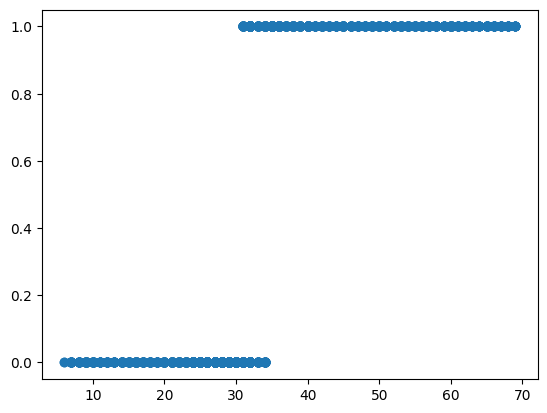

In [12]:
# Testing Dataset Gen2
dataset_1 = dataframe_gen2(male_df, female_df, percent=0.6, male_mean=20, female_mean=50, male_var=1, female_var=1)
dataset_1_male = dataset_1[dataset_1["gender"]==0]
dataset_1_female = dataset_1[dataset_1["gender"]==1]
print(dataset_1_male.age.values.mean())
print(dataset_1_female.age.values.mean())

print(dataset_1.nunique())
plt.scatter(dataset_1.age.values, dataset_1.gender.values)
plt.show()

4000 999


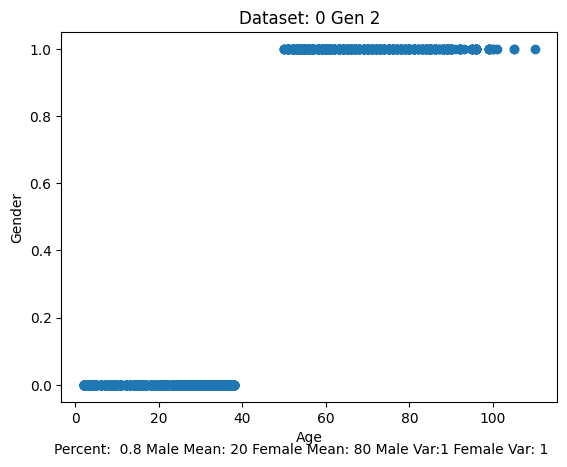

2500 2500


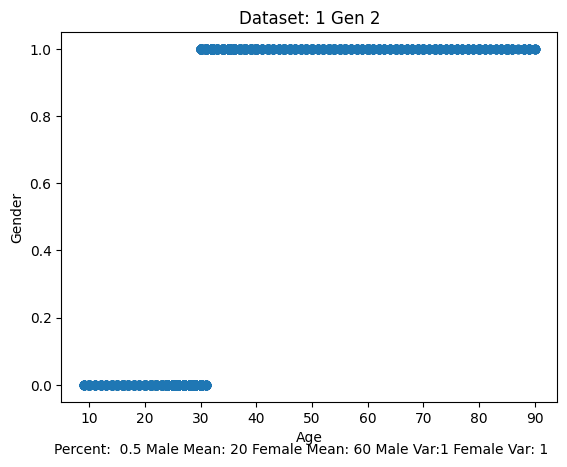

3000 2000


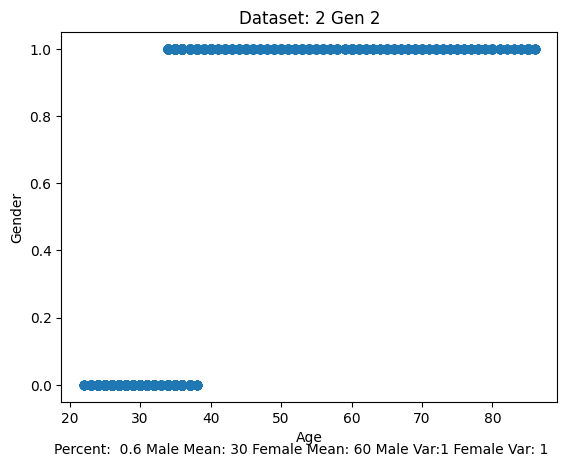

1500 3500


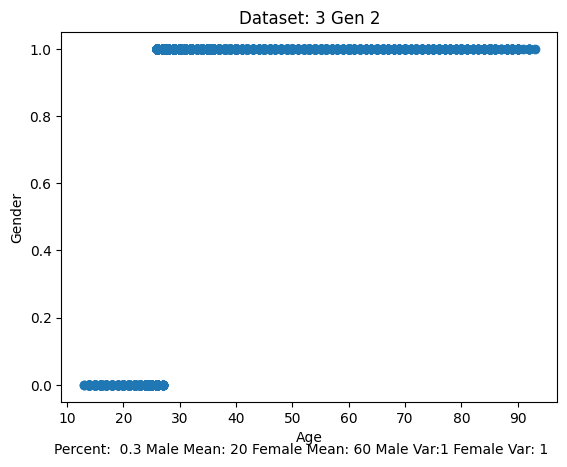

1500 3500


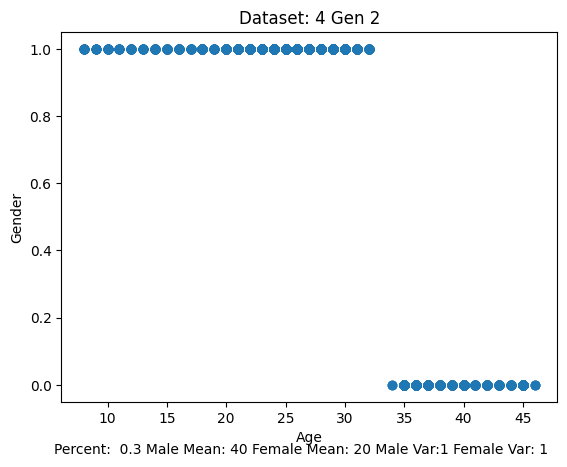

3500 1500


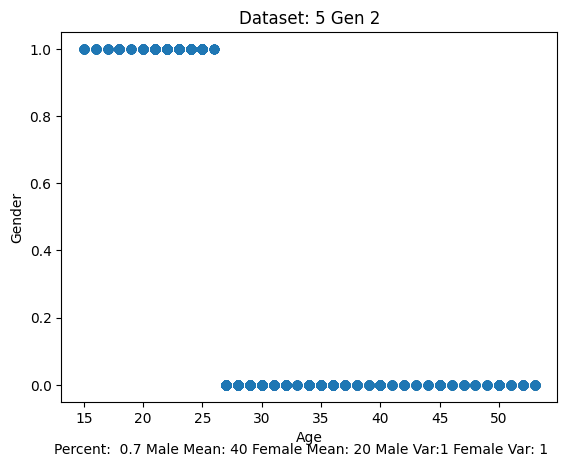

4000 999


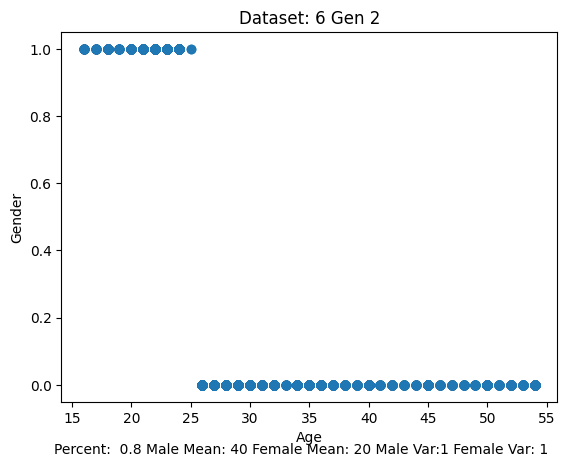

4000 999


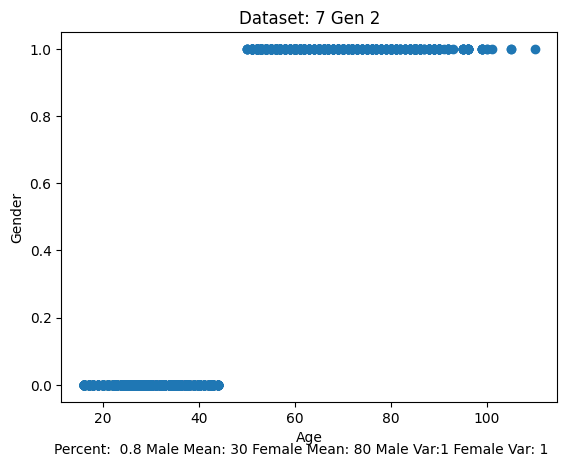

1000 4000


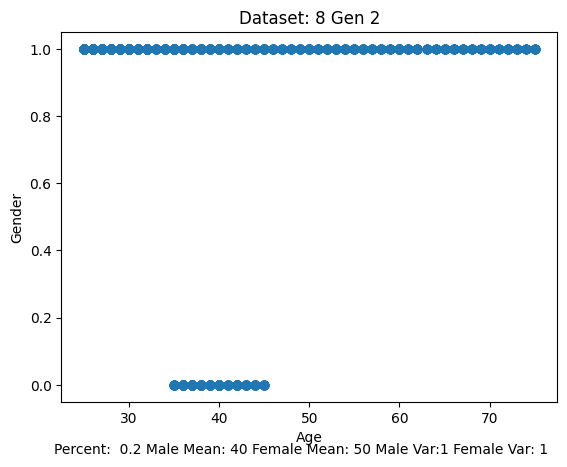

3000 2000


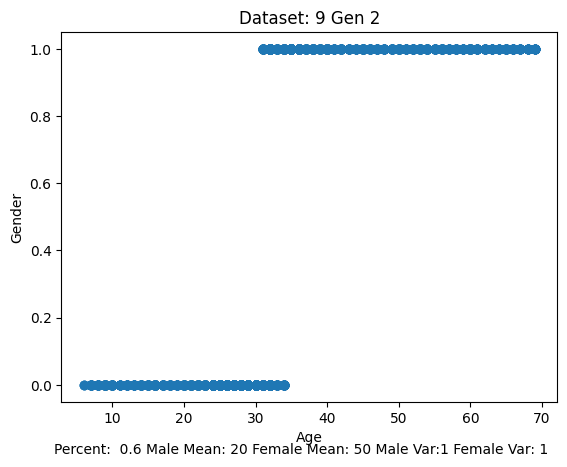

In [13]:
#Creating Dataframes using Gen2
percents = [0.8, 0.5, 0.6, 0.3, 0.3, 0.7, 0.8, 0.8, 0.2, 0.6]
male_means = [20, 20, 30, 20, 40, 40, 40, 30, 40, 20]
female_means = [80, 60, 60, 60, 20, 20, 20, 80, 50, 50]
male_vars = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]
female_vars = [1, 1, 1, 1, 1, 1, 1, 1, 1, 1]

dfs_gen2 = []
for i in range(len(percents)):
    df = dataframe_gen2(male_df, female_df, percent=percents[i], male_mean=male_means[i], female_mean=female_means[i], male_var=male_vars[i], female_var=female_vars[i])
    dfs_gen2.append(df)
    plt.scatter(df.age.values, df.gender.values)
    plt.title(f"Dataset: {i} Gen 2")
    plt.xlabel("Age")
    plt.ylabel("Gender")
    plt.figtext(0.5, 0.001, f"Percent:  {percents[i]} Male Mean: {male_means[i]} Female Mean: {female_means[i]} Male Var:{male_vars[i]} Female Var: {female_vars[i]}", wrap=True, horizontalalignment='center', fontsize=10)
    plt.savefig(f"./Datasets/Gen2/Dataset{i}.png")
    plt.show()

In [14]:
# Datasets and Dataloaders
##Datasets
NUM_TRAIN_DATASETS = len(threshs)
BATCH_SIZE = 128

custom_transform = transforms.Compose([transforms.Resize((128, 128)),
                                       transforms.RandomCrop((120, 120)),
                                       transforms.ToTensor()])

test_dataset = UTKFaceDataset(dataframe = test_df,
                              image_dir = DIR_PATH,
                              transform = custom_transform)

val_dataset = UTKFaceDataset(dataframe = val_df,
                             image_dir = DIR_PATH,
                             transform = custom_transform)
train_datasets = []
train_dataloaders = []
for i in range(NUM_TRAIN_DATASETS):
  train_dataset = UTKFaceDataset(dataframe = dfs_gen2[i],
                                 image_dir= DIR_PATH,
                                 transform = custom_transform)

  train_dataloader = DataLoader(dataset = train_dataset,
                                batch_size = BATCH_SIZE,
                                shuffle = True)

  train_dataloaders.append(train_dataloader)
  train_datasets.append(train_dataset)

##Dataloaders
test_dataloader = DataLoader(dataset = test_dataset,
                             shuffle = True,
                             batch_size = BATCH_SIZE)

val_dataloader = DataLoader(dataset = val_dataset,
                            batch_size = BATCH_SIZE,
                            shuffle = True)

# Bayesian Loss Limit

Calculating the errors of a Bayesian Regression Model which just uses Gender make predictions

Training Dataset0, Test Loss: 1101.9387859587043
Training Dataset1, Test Loss: 616.0688974849277
Training Dataset2, Test Loss: 625.3149452104078
Training Dataset3, Test Loss: 553.379336303103
Training Dataset4, Test Loss: 433.04035694550333
Training Dataset5, Test Loss: 445.7418063640179
Training Dataset6, Test Loss: 450.61506205558464
Training Dataset7, Test Loss: 1063.3822137858108
Training Dataset8, Test Loss: 427.9628900572872
Training Dataset9, Test Loss: 550.6855247897648
Full Trainig Dataset: 403.32285230872304


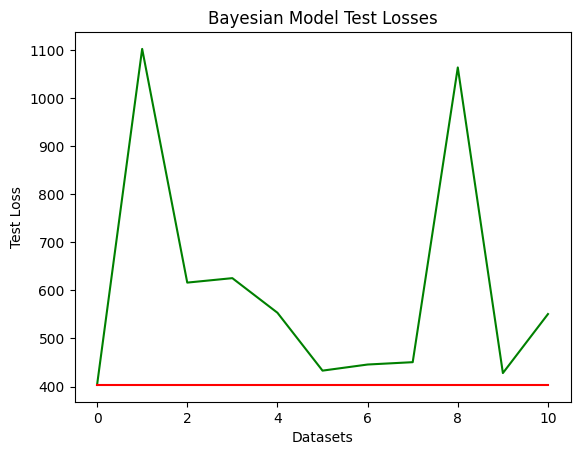

In [15]:
import sklearn
from sklearn import linear_model

test_losses_bayesian = []

for i in range(len(dfs_gen2)):
    df = dfs_gen2[i]
    
    x = df.gender.values
    x = x.reshape(-1,1)
    y = df.age.values

    #Bayesian Regression Model
    reg = linear_model.BayesianRidge()
    reg.fit(x, y)

    #Error Calculations
    x_test = test_df.gender.values
    x_test = x_test.reshape(-1,1)
    y_test = test_df.age.values

    y_pred = reg.predict(x_test)
    Loss = (np.square(y_test - y_pred)).mean()
    test_losses_bayesian.append(Loss)

    print(f"Training Dataset{i}, Test Loss: {Loss}")

#Bayesian on full dataset
x,y = train_df.gender.values, train_df.age.values
x = x.reshape(-1,1)
reg = linear_model.BayesianRidge()
reg.fit(x, y)

y_pred=reg.predict(x_test)
full_loss = (np.square(y_test - y_pred)).mean()
print("Full Trainig Dataset: {}".format(full_loss))
test_losses_bayesian.insert(0, full_loss)

#plotting the test loss of bayesian model in different datasets
plt.plot(range(len(test_losses_bayesian)), test_losses_bayesian, color='green')
plt.plot(range(len(test_losses_bayesian)), [full_loss]*len(test_losses_bayesian), color='red')
plt.title("Bayesian Model Test Losses")
plt.xlabel("Datasets")
plt.ylabel("Test Loss")
plt.show()

# CORAL Paper Implementation

In [16]:
# ResNet 34 model for Age Prediction
def conv3x3(in_planes, out_planes, stride=1):
    """3x3 convolution with padding"""
    return nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride,
                     padding=1, bias=False)

## Resnet Block
class BasicBlock(nn.Module):
    expansion = 1

    def __init__(self, inplanes, planes, stride=1, downsample=None):
        super(BasicBlock, self).__init__()
        self.conv1 = conv3x3(inplanes, planes, stride)
        self.bn1 = nn.BatchNorm2d(planes)
        self.relu = nn.ReLU(inplace=True)
        self.conv2 = conv3x3(planes, planes)
        self.bn2 = nn.BatchNorm2d(planes)
        self.downsample = downsample
        self.stride = stride

    def forward(self, x):
        residual = x
        
        out = self.conv1(x)
        out = self.bn1(out)
        out = self.relu(out)

        out = self.conv2(out)
        out = self.bn2(out)

        if self.downsample is not None:
            residual = self.downsample(x)

        out += residual
        out = self.relu(out)

        return out

## ResNet
class ResNet(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.num_classes = num_classes
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(ResNet, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, 1)

        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()

    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)
        return logits

## ResNet 34 model
def resnet34(num_classes, grayscale):
    """Constructs a ResNet-34 model."""
    model = ResNet(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   grayscale=grayscale)
    return model

In [17]:
## Model and Hyperparameters
model = resnet34(1, False).to(device) 

In [18]:
#Training the model
def train(model, train_dataloader, val_dataloader, lr = 0.0005, weight_decay = 0, epochs = 200, verbose = False):
  if verbose:
    print("Training the Model........")

  optimizer = optim.Adam(model.parameters(), lr = lr, weight_decay = weight_decay)

  losses = []
  val_losses = []
  model.train()

  for epoch in tqdm(range(epochs)):
    tloss = 0
    loss_num = 0

    for batch_idx, data in enumerate(train_dataloader):
      x, y = data
      x = x.to(torch.float32).to(device)
      y = y.reshape(y.shape[0], 1).to(torch.float32).to(device)

      optimizer.zero_grad()
      out = model(x)
      loss = F.mse_loss(out, y)
      loss.backward()
      optimizer.step()

      tloss += loss.detach().cpu()
      loss_num += 1

    with torch.no_grad():
      vloss = 0
      vloss_num = 0

      for batch_idx, data in enumerate(val_dataloader):
        x,y = data
        x = x.to(torch.float32).to(device)
        y = y.reshape(y.shape[0], 1).to(torch.float32).to(device)

        out = model(x)
        loss = F.mse_loss(out, y)

        vloss += loss.detach().cpu()
        vloss_num += 1

    if verbose:
      print(f"Epoch: {epoch}/{epochs} Training loss: {tloss / loss_num} Validation loss: {vloss / vloss_num}")

    losses.append(float(tloss / loss_num))
    val_losses.append(float(vloss / vloss_num))

  return model, losses, val_losses

# Evaluating the model
def eval_model(model, test_dataloader):
  test_loss = 0
  test_loss_num =0

  with torch.no_grad():
    for batch_idx, data in enumerate(test_dataloader):
      x,y = data
      x = x.to(torch.float32).to(device)
      y = y.reshape(y.shape[0], 1).to(torch.float32).to(device)

      out = model(x)
      loss = F.mse_loss(out, y)

      test_loss += loss.detach().cpu()
      test_loss_num += 1

  print(f"Test Loss: {float(test_loss / test_loss_num)}")
  return float(test_loss / test_loss_num)

In [15]:
model, train_losses, val_losses = train(model, train_dataloader=train_dataloaders[0], val_dataloader=val_dataloader, verbose = True, epochs=100)
test_loss = eval_model(model, test_dataloader)

Training the Model........
Epoch: 0/100 Training loss: 637.6976318359375 Validation loss: 349.0539245605469
Epoch: 1/100 Training loss: 141.08908081054688 Validation loss: 221.35914611816406
Epoch: 2/100 Training loss: 102.78802490234375 Validation loss: 210.0319366455078
Epoch: 3/100 Training loss: 95.54119873046875 Validation loss: 207.4215850830078
Epoch: 4/100 Training loss: 79.7380599975586 Validation loss: 168.82164001464844
Epoch: 5/100 Training loss: 67.19559478759766 Validation loss: 180.47410583496094
Epoch: 6/100 Training loss: 56.15272903442383 Validation loss: 166.9327392578125
Epoch: 7/100 Training loss: 55.677947998046875 Validation loss: 172.11444091796875
Epoch: 8/100 Training loss: 56.266944885253906 Validation loss: 159.03807067871094
Epoch: 9/100 Training loss: 44.7691764831543 Validation loss: 152.92491149902344
Epoch: 10/100 Training loss: 41.729339599609375 Validation loss: 148.8635711669922
Epoch: 11/100 Training loss: 53.971595764160156 Validation loss: 158.186

In [19]:
# Plotting the loss curves
epochs = 100
# Plotting function
def plot_loss_curves(train_losses, val_losses, test_loss, epochs, model_name = "resnet"):
    plt.plot(range(epochs), train_losses, color = 'blue', label = 'Training Loss')
    plt.plot(range(epochs), val_losses, color = 'red', label = 'Validation loss')
    plt.plot(range(epochs), [test_loss] * epochs, color = 'green', label = "Test Loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title(f"{model_name} loss curves")
    plt.show()

In [15]:
#plotting
plot_loss_curves(train_losses, val_losses, test_loss, epochs)

NameError: name 'plot_loss_curves' is not defined

In [20]:
# Training Dataset and Dataloader
comp_train_dataset = UTKFaceDataset(dataframe=train_df,
                                   image_dir = DIR_PATH,
                                   transform = custom_transform)
comp_train_dataloader = DataLoader(dataset = comp_train_dataset,
                                  batch_size = BATCH_SIZE,
                                  shuffle = True)

In [22]:
full_model = resnet34(1, False).to(device)
full_model, full_losses, full_vlosses = train(model, comp_train_dataloader, val_dataloader, epochs = 100, verbose = True)
full_test_loss = eval_model(model, test_dataloader)
torch.save(full_model.state_dict(), "./Models/full_model.pth")

Training the Model........


  1%|█▌                                                                                                                                                         | 1/100 [00:41<1:08:06, 41.28s/it]

Epoch: 0/100 Training loss: 407.72027587890625 Validation loss: 159.7054901123047


  2%|███                                                                                                                                                        | 2/100 [01:18<1:03:02, 38.60s/it]

Epoch: 1/100 Training loss: 127.554443359375 Validation loss: 116.08931732177734


  3%|████▋                                                                                                                                                      | 3/100 [01:55<1:01:15, 37.89s/it]

Epoch: 2/100 Training loss: 107.1889419555664 Validation loss: 106.64752197265625


  4%|██████▏                                                                                                                                                    | 4/100 [02:32<1:00:26, 37.78s/it]

Epoch: 3/100 Training loss: 89.40238189697266 Validation loss: 92.81407165527344


  5%|███████▊                                                                                                                                                     | 5/100 [03:10<59:40, 37.68s/it]

Epoch: 4/100 Training loss: 84.75157928466797 Validation loss: 84.75932312011719


  6%|█████████▍                                                                                                                                                   | 6/100 [03:48<59:16, 37.83s/it]

Epoch: 5/100 Training loss: 74.35176086425781 Validation loss: 83.7119369506836


  7%|██████████▊                                                                                                                                                | 7/100 [04:29<1:00:33, 39.07s/it]

Epoch: 6/100 Training loss: 69.507568359375 Validation loss: 83.52178192138672


  8%|████████████▌                                                                                                                                                | 8/100 [05:08<59:43, 38.95s/it]

Epoch: 7/100 Training loss: 63.56819534301758 Validation loss: 89.8721923828125


  9%|█████████████▉                                                                                                                                             | 9/100 [05:50<1:00:33, 39.93s/it]

Epoch: 8/100 Training loss: 59.15048599243164 Validation loss: 85.87333679199219


 10%|███████████████▌                                                                                                                                            | 10/100 [06:30<59:43, 39.82s/it]

Epoch: 9/100 Training loss: 60.68708038330078 Validation loss: 87.0700912475586


 11%|█████████████████▏                                                                                                                                          | 11/100 [07:10<59:18, 39.98s/it]

Epoch: 10/100 Training loss: 53.70991897583008 Validation loss: 79.0096206665039


 12%|██████████████████▋                                                                                                                                         | 12/100 [07:51<58:58, 40.21s/it]

Epoch: 11/100 Training loss: 47.169151306152344 Validation loss: 77.2950668334961


 13%|████████████████████▎                                                                                                                                       | 13/100 [08:30<57:50, 39.89s/it]

Epoch: 12/100 Training loss: 50.711971282958984 Validation loss: 81.03874969482422


 14%|█████████████████████▊                                                                                                                                      | 14/100 [09:16<59:36, 41.59s/it]

Epoch: 13/100 Training loss: 46.69129180908203 Validation loss: 81.22478485107422


 15%|███████████████████████▍                                                                                                                                    | 15/100 [09:55<57:52, 40.85s/it]

Epoch: 14/100 Training loss: 44.1159553527832 Validation loss: 79.12760162353516


 16%|████████████████████████▉                                                                                                                                   | 16/100 [10:35<57:02, 40.74s/it]

Epoch: 15/100 Training loss: 38.284854888916016 Validation loss: 76.61612701416016


 17%|██████████████████████████▌                                                                                                                                 | 17/100 [11:15<56:07, 40.57s/it]

Epoch: 16/100 Training loss: 38.64206314086914 Validation loss: 76.14707946777344


 18%|████████████████████████████                                                                                                                                | 18/100 [11:55<55:07, 40.34s/it]

Epoch: 17/100 Training loss: 33.59965133666992 Validation loss: 79.09991455078125


 19%|█████████████████████████████▋                                                                                                                              | 19/100 [12:36<54:38, 40.48s/it]

Epoch: 18/100 Training loss: 33.681732177734375 Validation loss: 81.46034240722656


 20%|███████████████████████████████▏                                                                                                                            | 20/100 [13:16<53:51, 40.40s/it]

Epoch: 19/100 Training loss: 33.465736389160156 Validation loss: 74.85529327392578


 21%|████████████████████████████████▊                                                                                                                           | 21/100 [13:55<52:43, 40.05s/it]

Epoch: 20/100 Training loss: 27.180438995361328 Validation loss: 67.8237075805664


 22%|██████████████████████████████████▎                                                                                                                         | 22/100 [14:36<52:11, 40.15s/it]

Epoch: 21/100 Training loss: 30.52943992614746 Validation loss: 73.76728820800781


 23%|███████████████████████████████████▉                                                                                                                        | 23/100 [15:16<51:28, 40.11s/it]

Epoch: 22/100 Training loss: 29.576568603515625 Validation loss: 77.78179168701172


 24%|█████████████████████████████████████▍                                                                                                                      | 24/100 [15:56<50:57, 40.23s/it]

Epoch: 23/100 Training loss: 25.982336044311523 Validation loss: 72.5457992553711


 25%|███████████████████████████████████████                                                                                                                     | 25/100 [16:37<50:31, 40.43s/it]

Epoch: 24/100 Training loss: 22.81153678894043 Validation loss: 70.90084838867188


 26%|████████████████████████████████████████▌                                                                                                                   | 26/100 [17:18<49:51, 40.43s/it]

Epoch: 25/100 Training loss: 27.150754928588867 Validation loss: 74.0699234008789


 27%|██████████████████████████████████████████                                                                                                                  | 27/100 [17:58<49:09, 40.40s/it]

Epoch: 26/100 Training loss: 23.68161392211914 Validation loss: 77.27184295654297


 28%|███████████████████████████████████████████▋                                                                                                                | 28/100 [18:38<48:32, 40.45s/it]

Epoch: 27/100 Training loss: 20.529855728149414 Validation loss: 71.89373016357422


 29%|█████████████████████████████████████████████▏                                                                                                              | 29/100 [19:18<47:38, 40.26s/it]

Epoch: 28/100 Training loss: 19.426774978637695 Validation loss: 79.35758972167969


 30%|██████████████████████████████████████████████▊                                                                                                             | 30/100 [19:58<46:55, 40.23s/it]

Epoch: 29/100 Training loss: 19.672866821289062 Validation loss: 68.00057220458984


 31%|████████████████████████████████████████████████▎                                                                                                           | 31/100 [20:38<46:06, 40.10s/it]

Epoch: 30/100 Training loss: 16.434463500976562 Validation loss: 69.36783599853516


 32%|█████████████████████████████████████████████████▉                                                                                                          | 32/100 [21:18<45:15, 39.93s/it]

Epoch: 31/100 Training loss: 16.001413345336914 Validation loss: 77.48125457763672


 33%|███████████████████████████████████████████████████▍                                                                                                        | 33/100 [21:58<44:48, 40.13s/it]

Epoch: 32/100 Training loss: 18.013790130615234 Validation loss: 77.58187103271484


 34%|█████████████████████████████████████████████████████                                                                                                       | 34/100 [22:38<44:07, 40.11s/it]

Epoch: 33/100 Training loss: 17.049823760986328 Validation loss: 68.55298614501953


 35%|██████████████████████████████████████████████████████▌                                                                                                     | 35/100 [23:18<43:25, 40.09s/it]

Epoch: 34/100 Training loss: 17.64322280883789 Validation loss: 72.7080078125


 36%|████████████████████████████████████████████████████████▏                                                                                                   | 36/100 [24:00<43:12, 40.50s/it]

Epoch: 35/100 Training loss: 14.92263126373291 Validation loss: 69.94232177734375


 37%|█████████████████████████████████████████████████████████▋                                                                                                  | 37/100 [24:43<43:12, 41.14s/it]

Epoch: 36/100 Training loss: 15.55790901184082 Validation loss: 68.11903381347656


 38%|███████████████████████████████████████████████████████████▎                                                                                                | 38/100 [25:22<41:53, 40.54s/it]

Epoch: 37/100 Training loss: 15.614068984985352 Validation loss: 66.4748306274414


 39%|████████████████████████████████████████████████████████████▊                                                                                               | 39/100 [26:03<41:27, 40.78s/it]

Epoch: 38/100 Training loss: 18.84457778930664 Validation loss: 75.7334976196289


 40%|██████████████████████████████████████████████████████████████▍                                                                                             | 40/100 [26:43<40:32, 40.55s/it]

Epoch: 39/100 Training loss: 16.752538681030273 Validation loss: 69.70745849609375


 41%|███████████████████████████████████████████████████████████████▉                                                                                            | 41/100 [27:23<39:42, 40.39s/it]

Epoch: 40/100 Training loss: 14.520405769348145 Validation loss: 67.62401580810547


 42%|█████████████████████████████████████████████████████████████████▌                                                                                          | 42/100 [28:04<39:17, 40.64s/it]

Epoch: 41/100 Training loss: 14.229775428771973 Validation loss: 71.57698059082031


 43%|███████████████████████████████████████████████████████████████████                                                                                         | 43/100 [28:43<38:09, 40.16s/it]

Epoch: 42/100 Training loss: 14.440664291381836 Validation loss: 78.7094497680664


 44%|████████████████████████████████████████████████████████████████████▋                                                                                       | 44/100 [29:25<37:53, 40.60s/it]

Epoch: 43/100 Training loss: 11.97784423828125 Validation loss: 65.45916748046875


 45%|██████████████████████████████████████████████████████████████████████▏                                                                                     | 45/100 [30:07<37:36, 41.02s/it]

Epoch: 44/100 Training loss: 10.454360008239746 Validation loss: 65.16043853759766


 46%|███████████████████████████████████████████████████████████████████████▊                                                                                    | 46/100 [30:50<37:30, 41.68s/it]

Epoch: 45/100 Training loss: 10.405718803405762 Validation loss: 66.90106201171875


 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                  | 47/100 [31:30<36:20, 41.14s/it]

Epoch: 46/100 Training loss: 10.432942390441895 Validation loss: 66.77703094482422


 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                 | 48/100 [32:10<35:21, 40.80s/it]

Epoch: 47/100 Training loss: 10.608920097351074 Validation loss: 68.2132339477539


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 49/100 [32:51<34:43, 40.85s/it]

Epoch: 48/100 Training loss: 9.795012474060059 Validation loss: 65.9963607788086


 50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 50/100 [33:31<33:46, 40.52s/it]

Epoch: 49/100 Training loss: 10.16041088104248 Validation loss: 67.28673553466797


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 51/100 [34:12<33:16, 40.75s/it]

Epoch: 50/100 Training loss: 10.158469200134277 Validation loss: 69.63367462158203


 52%|█████████████████████████████████████████████████████████████████████████████████                                                                           | 52/100 [34:51<32:13, 40.28s/it]

Epoch: 51/100 Training loss: 8.920031547546387 Validation loss: 66.06654357910156


 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                         | 53/100 [35:34<32:00, 40.87s/it]

Epoch: 52/100 Training loss: 8.48011589050293 Validation loss: 68.28852081298828


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 54/100 [36:13<30:59, 40.42s/it]

Epoch: 53/100 Training loss: 8.953848838806152 Validation loss: 66.31624603271484


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 55/100 [36:52<30:01, 40.03s/it]

Epoch: 54/100 Training loss: 11.500215530395508 Validation loss: 108.83831787109375


 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 56/100 [37:38<30:34, 41.70s/it]

Epoch: 55/100 Training loss: 47.36488723754883 Validation loss: 86.54684448242188


 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 57/100 [38:19<29:53, 41.71s/it]

Epoch: 56/100 Training loss: 30.04367446899414 Validation loss: 69.72256469726562


 58%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 58/100 [39:00<28:54, 41.29s/it]

Epoch: 57/100 Training loss: 14.321098327636719 Validation loss: 67.49505615234375


 59%|████████████████████████████████████████████████████████████████████████████████████████████                                                                | 59/100 [39:41<28:15, 41.36s/it]

Epoch: 58/100 Training loss: 11.1074857711792 Validation loss: 65.45661163330078


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 60/100 [40:22<27:25, 41.15s/it]

Epoch: 59/100 Training loss: 8.457686424255371 Validation loss: 68.0583724975586


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 61/100 [41:05<27:03, 41.62s/it]

Epoch: 60/100 Training loss: 8.381793022155762 Validation loss: 67.50426483154297


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 62/100 [41:46<26:16, 41.49s/it]

Epoch: 61/100 Training loss: 7.267120838165283 Validation loss: 69.1309585571289


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 63/100 [42:29<25:59, 42.16s/it]

Epoch: 62/100 Training loss: 7.2414164543151855 Validation loss: 65.32917022705078


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 64/100 [43:11<25:15, 42.11s/it]

Epoch: 63/100 Training loss: 6.115442752838135 Validation loss: 63.42991256713867


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 65/100 [43:53<24:28, 41.95s/it]

Epoch: 64/100 Training loss: 6.356719970703125 Validation loss: 67.80416107177734


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 66/100 [44:34<23:39, 41.74s/it]

Epoch: 65/100 Training loss: 5.543104648590088 Validation loss: 64.285888671875


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 67/100 [45:15<22:51, 41.55s/it]

Epoch: 66/100 Training loss: 5.550139904022217 Validation loss: 66.13368225097656


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 68/100 [45:55<21:52, 41.03s/it]

Epoch: 67/100 Training loss: 5.365570068359375 Validation loss: 66.16043853759766


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 69/100 [46:35<21:04, 40.80s/it]

Epoch: 68/100 Training loss: 5.580009937286377 Validation loss: 66.1858901977539


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 70/100 [47:17<20:28, 40.94s/it]

Epoch: 69/100 Training loss: 5.558287143707275 Validation loss: 62.63231658935547


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 71/100 [48:00<20:10, 41.75s/it]

Epoch: 70/100 Training loss: 5.251992702484131 Validation loss: 64.10868835449219


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 72/100 [48:41<19:23, 41.54s/it]

Epoch: 71/100 Training loss: 5.337039947509766 Validation loss: 67.10982513427734


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 73/100 [49:23<18:40, 41.51s/it]

Epoch: 72/100 Training loss: 5.189208507537842 Validation loss: 62.725772857666016


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 74/100 [50:06<18:12, 42.02s/it]

Epoch: 73/100 Training loss: 5.7148237228393555 Validation loss: 68.12103271484375


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 75/100 [50:46<17:11, 41.27s/it]

Epoch: 74/100 Training loss: 6.656029224395752 Validation loss: 65.14201354980469


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 76/100 [51:27<16:34, 41.45s/it]

Epoch: 75/100 Training loss: 5.599625110626221 Validation loss: 65.43551635742188


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 77/100 [52:09<15:53, 41.44s/it]

Epoch: 76/100 Training loss: 5.549320697784424 Validation loss: 64.5837631225586


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 78/100 [52:52<15:20, 41.83s/it]

Epoch: 77/100 Training loss: 5.598494052886963 Validation loss: 62.528656005859375


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 79/100 [53:34<14:39, 41.90s/it]

Epoch: 78/100 Training loss: 5.113371849060059 Validation loss: 67.74098205566406


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 80/100 [54:17<14:06, 42.31s/it]

Epoch: 79/100 Training loss: 5.065004825592041 Validation loss: 64.32760620117188


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 81/100 [55:00<13:26, 42.47s/it]

Epoch: 80/100 Training loss: 5.152034759521484 Validation loss: 63.168617248535156


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 82/100 [55:40<12:32, 41.79s/it]

Epoch: 81/100 Training loss: 5.060207366943359 Validation loss: 66.82420349121094


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 83/100 [56:20<11:39, 41.17s/it]

Epoch: 82/100 Training loss: 5.891847133636475 Validation loss: 63.999576568603516


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 84/100 [57:01<10:58, 41.18s/it]

Epoch: 83/100 Training loss: 5.69547176361084 Validation loss: 67.36473083496094


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 85/100 [57:42<10:19, 41.27s/it]

Epoch: 84/100 Training loss: 5.642075061798096 Validation loss: 66.23931884765625


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/100 [58:25<09:42, 41.61s/it]

Epoch: 85/100 Training loss: 5.514216423034668 Validation loss: 66.02173614501953


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 87/100 [59:07<09:02, 41.71s/it]

Epoch: 86/100 Training loss: 7.5766096115112305 Validation loss: 86.9559097290039


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 88/100 [59:47<08:14, 41.23s/it]

Epoch: 87/100 Training loss: 35.94893264770508 Validation loss: 75.00960540771484


 89%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                 | 89/100 [1:00:30<07:39, 41.80s/it]

Epoch: 88/100 Training loss: 15.070849418640137 Validation loss: 65.07671356201172


 90%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌               | 90/100 [1:01:12<06:57, 41.73s/it]

Epoch: 89/100 Training loss: 7.883814811706543 Validation loss: 64.39547729492188


 91%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏             | 91/100 [1:01:53<06:14, 41.62s/it]

Epoch: 90/100 Training loss: 6.252129554748535 Validation loss: 63.95219421386719


 92%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋            | 92/100 [1:02:34<05:31, 41.38s/it]

Epoch: 91/100 Training loss: 4.83701229095459 Validation loss: 63.77271270751953


 93%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏          | 93/100 [1:03:14<04:46, 40.96s/it]

Epoch: 92/100 Training loss: 4.1841816902160645 Validation loss: 63.445640563964844


 94%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊         | 94/100 [1:03:55<04:05, 40.99s/it]

Epoch: 93/100 Training loss: 3.9048614501953125 Validation loss: 63.472900390625


 95%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎       | 95/100 [1:04:42<03:34, 42.90s/it]

Epoch: 94/100 Training loss: 3.863115072250366 Validation loss: 65.36019134521484


 96%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 96/100 [1:05:28<02:54, 43.67s/it]

Epoch: 95/100 Training loss: 3.583923816680908 Validation loss: 61.71787643432617


 97%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍    | 97/100 [1:06:06<02:06, 42.22s/it]

Epoch: 96/100 Training loss: 3.362483501434326 Validation loss: 62.504676818847656


 98%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 98/100 [1:06:48<01:24, 42.06s/it]

Epoch: 97/100 Training loss: 3.3592283725738525 Validation loss: 62.39314270019531


 99%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 99/100 [1:07:31<00:42, 42.28s/it]

Epoch: 98/100 Training loss: 3.6823525428771973 Validation loss: 65.2373275756836


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:08:12<00:00, 40.93s/it]

Epoch: 99/100 Training loss: 3.584869623184204 Validation loss: 63.3243522644043


Test Loss: 72.61416625976562


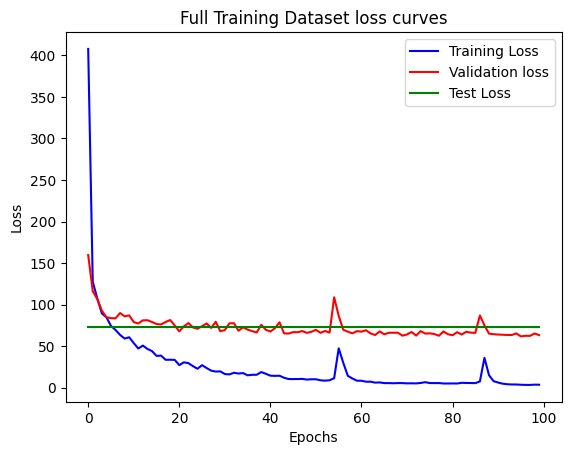

In [23]:
#plotting loss curves for the entire training dataset
plot_loss_curves(full_losses, full_vlosses, full_test_loss, epochs, model_name="Full Training Dataset")

In [20]:
# Training models on different Training Datasets
models = []
tlosses = []
vlosses = []
tst_losses = []

for i in range(len(train_dataloaders)):
    print(f"Training dataset {i}")
    model = resnet34(1, False).to(device)
    model, train_losses, val_losses = train(model, train_dataloaders[i], val_dataloader, verbose = False, epochs = 100)
    test_loss = eval_model(model, test_dataloader)

    tlosses.append(train_losses)
    vlosses.append(val_losses)
    tst_losses.append(test_loss)

    torch.save(model.state_dict(), f"./Models/Gen2_models/model{i}.pth")
    print(f"Model saved to ./Models/Gen2_models/model{i}.pth")

Training dataset 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [30:02<00:00, 18.02s/it]


Test Loss: 167.07644653320312
Model saved to ./Models/Gen2_models/model0.pth
Training dataset 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [30:16<00:00, 18.17s/it]


Test Loss: 184.7777862548828
Model saved to ./Models/Gen2_models/model1.pth
Training dataset 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [30:00<00:00, 18.00s/it]


Test Loss: 347.7750549316406
Model saved to ./Models/Gen2_models/model2.pth
Training dataset 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [29:45<00:00, 17.86s/it]


Test Loss: 202.0666046142578
Model saved to ./Models/Gen2_models/model3.pth
Training dataset 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [29:52<00:00, 17.93s/it]


Test Loss: 250.9844512939453
Model saved to ./Models/Gen2_models/model4.pth
Training dataset 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [29:48<00:00, 17.88s/it]


Test Loss: 226.62294006347656
Model saved to ./Models/Gen2_models/model5.pth
Training dataset 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [29:48<00:00, 17.88s/it]


Test Loss: 229.2008819580078
Model saved to ./Models/Gen2_models/model6.pth
Training dataset 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [29:44<00:00, 17.84s/it]


Test Loss: 353.51263427734375
Model saved to ./Models/Gen2_models/model7.pth
Training dataset 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [29:49<00:00, 17.90s/it]


Test Loss: 285.98394775390625
Model saved to ./Models/Gen2_models/model8.pth
Training dataset 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [29:57<00:00, 17.97s/it]


Test Loss: 194.95729064941406
Model saved to ./Models/Gen2_models/model9.pth


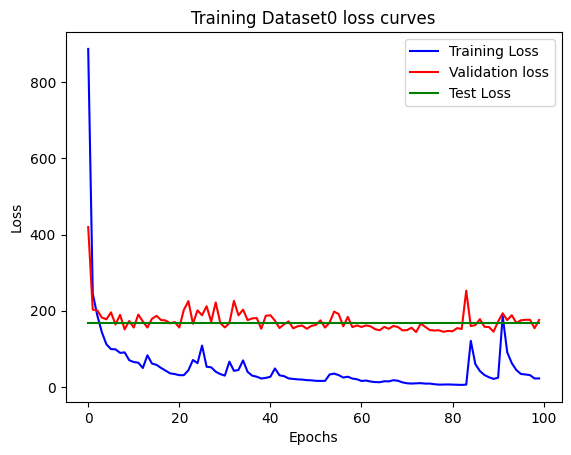

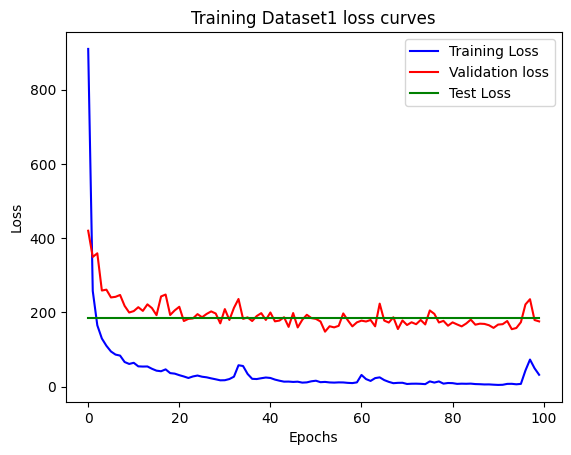

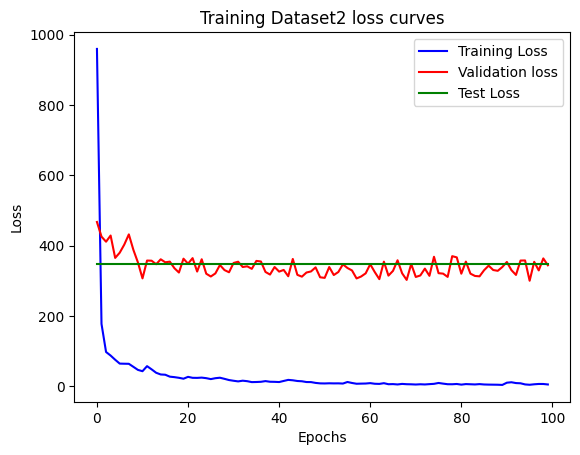

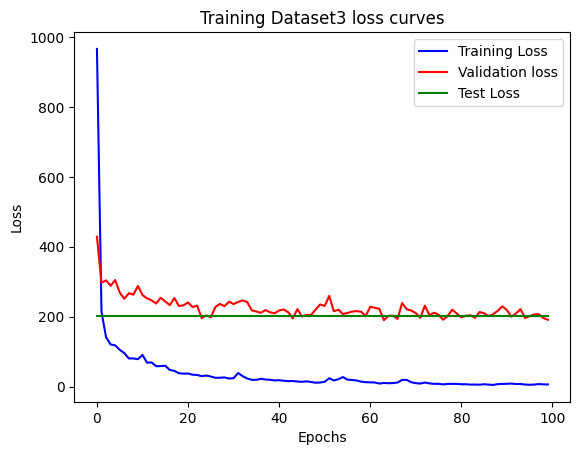

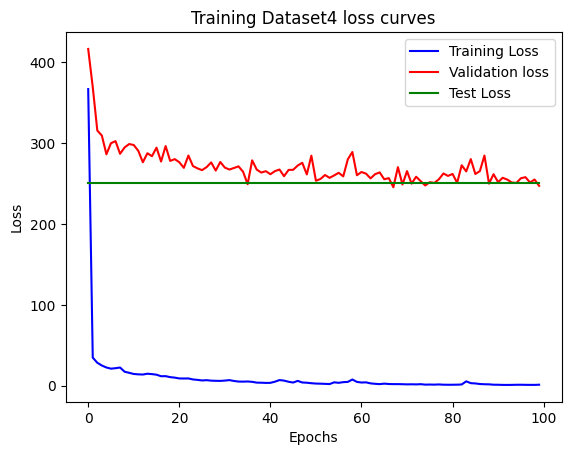

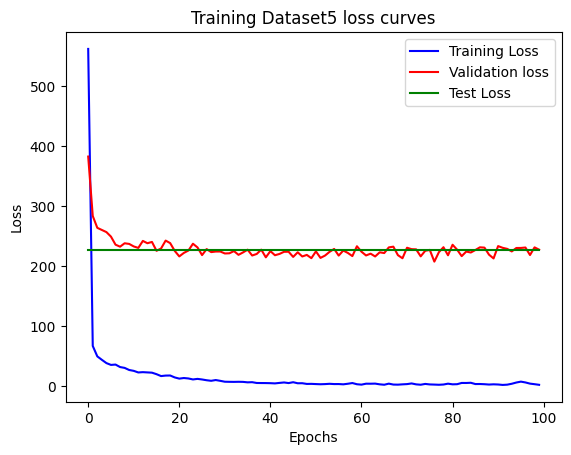

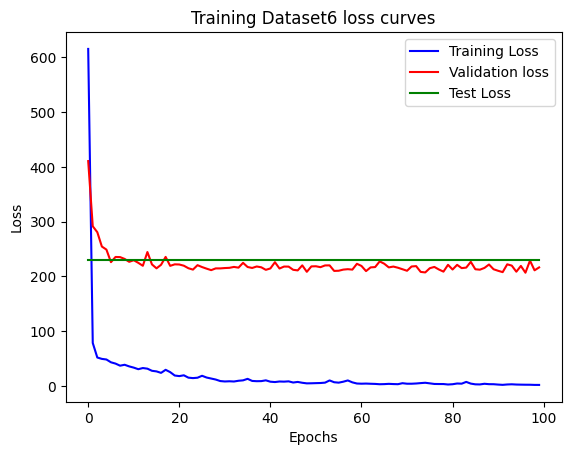

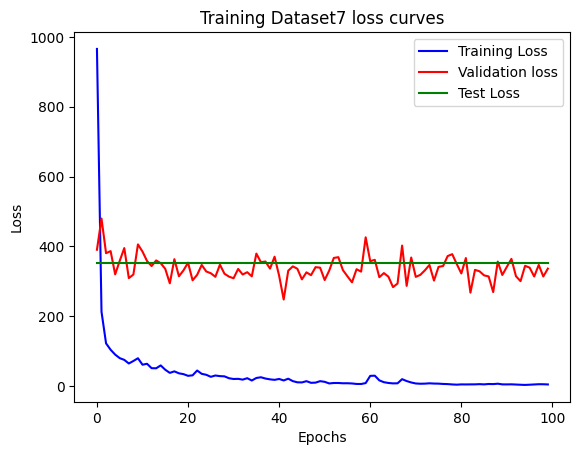

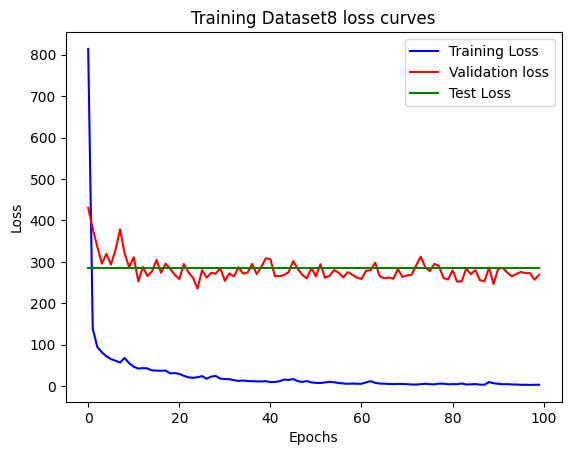

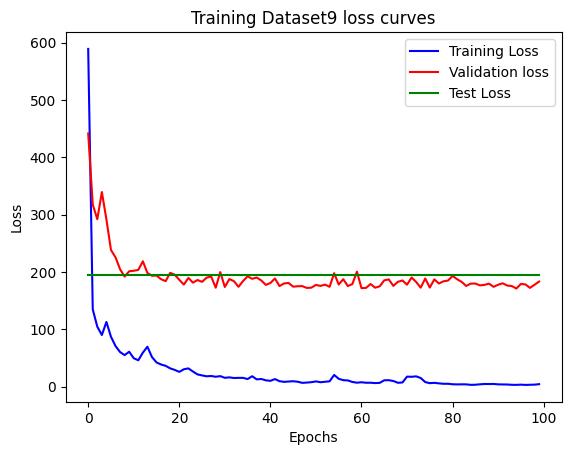

In [21]:
#plotting graphs:
for i in range(len(tlosses)):
    plot_loss_curves(tlosses[i], vlosses[i], tst_losses[i], epochs, model_name=f"Training Dataset{i}")

# Feature Sieve Regression
## 1) Forgetting loss: Margin Loss

In [21]:
class Feature_Sieve_Margin(nn.Module):

    def __init__(self, block, layers, num_classes, grayscale):
        self.num_classes = num_classes
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(Feature_Sieve_Margin, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, 1)

        self.inplanes = 64
        self.auxlayer1 = self._make_layer(block, 64, layers[0])
        self.auxlayer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.aux_avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.aux_fc = nn.Linear(21632, 1)
        # self.aux_out = nn.Linear(128, 1)
        

        self.params = nn.ModuleDict({
            "main": nn.ModuleList([self.conv1, self.bn1, self.relu, self.maxpool, self.layer1, self.layer2, self.layer3, self.layer4, self.avgpool, self.fc]),
            "aux": nn.ModuleList([ self.auxlayer1, self.auxlayer2, self.aux_avgpool, self.aux_fc]),
            "forget": nn.ModuleList([self.conv1, self.bn1, self.relu, self.maxpool, self.layer1])
        })

    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        sh = self.maxpool(x)
        

        #forward of the main network
        x = self.layer1(sh)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        #forward of aux network
        aux = self.auxlayer1(sh)
        aux = self.auxlayer2(aux)
        aux = self.aux_avgpool(aux)
        aux = aux.view(aux.size(0), -1)
        aux = self.aux_fc(aux)
        # aux = self.aux_out(aux)
        
        
        return logits, aux

def fs_margin(num_classes, grayscale):
    """Constructs a ResNet-34 model."""
    model = Feature_Sieve_Margin(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   grayscale=grayscale)
    return model

In [22]:
fs_mar_model = fs_margin(1, False).to(device)

In [23]:
## Forget Loss: Margin Loss
def learn_main(model, optim_main, x, y):
    model.train()
    optim_main.zero_grad()
    out = model(x)[0]
    loss = F.mse_loss(out, y)
    loss.backward()
    optim_main.step()
    optim_main.zero_grad()
    model.eval()


def learn_aux(model, optim_main, optim_aux, x, y, alpha_aux = 1):
    model.train()
    optim_main.zero_grad()
    aux = model(x)[1]
    loss = alpha_aux * F.mse_loss(aux, y)
    loss.backward()
    optim_aux.step()
    optim_aux.zero_grad()
    model.eval()

def forget_aux(model, optim_forget, x, y, margin):
    model.train()
    optim_forget.zero_grad()
    aux = model(x)[1]
    mse_loss = F.mse_loss(aux,y)
    thresh = torch.tensor(-margin).to(torch.float32).to(device)
    loss = torch.max(thresh, -mse_loss)
    loss.backward()
    optim_forget.step()
    optim_forget.zero_grad()
    model.eval()

In [24]:
def train_fs_mar(model, train_dataloader, val_dataloader, epochs = 100, margin=10, aux_iters=1, main_iters=1, forget_iters=10, verbose=False, lrs=[0.0005, 0.0005, 0.0005], wds = [0,0,0]):
    if verbose:
        print("Training model...............")
    train_losses= []
    val_losses = []

    optim_main = optim.Adam(model.params.main.parameters(),lr=lrs[0], weight_decay=wds[0])
    optim_aux = optim.Adam(model.params.aux.parameters(), lr=lrs[1], weight_decay=wds[1])
    optim_forget = optim.Adam(model.params.forget.parameters(), lr=lrs[2], weight_decay=wds[2])

    steps = 0

    for epoch in tqdm(range(epochs)):
        tloss = 0
        loss_num = 0

        for batch_idx, data in enumerate(train_dataloader):
            x,y = data
            x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)

            if main_iters and steps % main_iters == 0:
                learn_main(model, optim_main, x, y)
            if aux_iters and steps % aux_iters == 0:
                learn_aux(model, optim_main, optim_aux, x, y)
            if forget_iters and steps % forget_iters == 0:
                forget_aux(model, optim_forget, x, y, margin)

            with torch.no_grad():
                out = model(x)[0]
                loss = F.mse_loss(out, y)

                tloss += loss.detach().cpu()
                loss_num += 1
                steps += 1

        with torch.no_grad():
            vloss = 0
            vloss_num = 0
            
            for batch_idx, data in enumerate(val_dataloader):
                x,y = data
                x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)

                out = model(x)[0]
                loss = F.mse_loss(out, y)

                vloss += loss.detach().cpu()
                vloss_num += 1
                
        if verbose:
            print(f"Epochs: {epoch+1}/{epochs} Training Loss: {float(tloss / loss_num)} Validation Loss: {float(vloss / vloss_num)}")
            
        train_losses.append(float(tloss/ loss_num))
        val_losses.append(float(vloss / vloss_num))

    return model, train_losses, val_losses

def eval_FSModel(model, test_dataloader):
    with torch.no_grad():
        tst_loss = 0
        loss_num = 0

        for batch_idx, data in enumerate(test_dataloader):
            x,y = data
            x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)

            out = model(x)[0]
            loss = F.mse_loss(out, y)

            tst_loss += loss.detach().cpu()
            loss_num += 1

        print(f"Test Loss: {float(tst_loss / loss_num)}")
    return float(tst_loss / loss_num)

In [77]:
epochs = 5
fs_mar_model, fs_mar_losses, fs_mar_val_losses = train_fs_mar(fs_mar_model, train_dataloaders[0], val_dataloader, epochs=epochs, verbose = True)
fs_mar_test_loss = eval_FSModel(fs_mar_model, test_dataloader)

Training model...............


 20%|███████████████████████████▊                                                                                                               | 1/5 [00:25<01:40, 25.16s/it]

Epochs: 1/5 Training Loss: 865.9900512695312 Validation Loss: 1626.9755859375


 40%|███████████████████████████████████████████████████████▌                                                                                   | 2/5 [00:53<01:21, 27.06s/it]

Epochs: 2/5 Training Loss: 442.9397888183594 Validation Loss: 713.04833984375


 60%|███████████████████████████████████████████████████████████████████████████████████▍                                                       | 3/5 [01:21<00:55, 27.54s/it]

Epochs: 3/5 Training Loss: 233.3225555419922 Validation Loss: 266.5513610839844


 80%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                           | 4/5 [01:49<00:27, 27.85s/it]

Epochs: 4/5 Training Loss: 196.66453552246094 Validation Loss: 776.1011962890625


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.76s/it]

Epochs: 5/5 Training Loss: 152.196533203125 Validation Loss: 170.92538452148438


Test Loss: 167.71636962890625


In [ ]:
#plotting
epochs = 100
plt.plot(range(epochs), fs_mar_losses, color = "blue", label = "Training Loss")
plt.plot(range(epochs), fs_mar_val_losses, color = "red", label = "Validation Loss")
plt.plot(range(epochs), [fs_mar_test_loss]*epochs, color = "green", label = "Test Loss")
plt.legend()
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Feature Sieve: Margin Forgeting Loss")
plt.show()

In [38]:
# Hyperparameter Tuning
margins = [5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 150, 200]
forget_lrs = [1e-5, 5e-5, 2e-5, 2e-4, 5e-4, 1e-4, 1e-3, 2e-3, 8e-3, 5e-3, 1e-2, 5e-2, 1e-1]
forget_iters = [2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]

test_losses = []
for i in range(len(forget_lrs)):
    print(f"Forget LR: {forget_lrs[i]}")
    model = fs_margin(1, False).to(device)
    model, tloss, vloss = train_fs_mar(model, train_dataloaders[0], val_dataloader, lrs = [0.0005, 0.0005, forget_lrs[i]], verbose=False, epochs=5)
    tst_loss = eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)

best_forget_lr = forget_lrs[test_losses.index(min(test_losses))]
print(f"Best Forget Lr: {best_forget_lr}")

test_losses = []
for i in range(len(forget_iters)):
    print(f"Forget Iter: {forget_iters[i]}")
    model = fs_margin(1, False).to(device)
    model, tloss, vloss = train_fs_mar(model, train_dataloaders[0], val_dataloader, lrs=[0.0005, 0.0005, best_forget_lr], forget_iters=forget_iters[i], verbose=False, epochs=5)
    tst_loss= eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)

best_forget_iter = forget_iters[test_losses.index(min(test_losses))]
print(f"Best Forget Iter :{best_forget_iter}")

test_losses = []
for i in range(len(margins)):
    print(f"Margin: {margins[i]}")
    model = fs_margin(1, False).to(device)
    model, tloss, vloss = train_fs_mar(model, train_dataloaders[0], val_dataloader, margin=margins[i], forget_iters=best_forget_iter, lrs=[0.0005,0.0005,best_forget_lr], epochs=5, verbose=False)
    tst_loss = eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)

best_margin = margins[test_losses.index(min(test_losses))]
print(f"Best Margin: {best_margin}")

Forget LR: 1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.73s/it]


Test Loss: 337.002197265625
Forget LR: 5e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:29<00:00, 29.91s/it]


Test Loss: 191.46261596679688
Forget LR: 2e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:25<00:00, 29.05s/it]


Test Loss: 242.18870544433594
Forget LR: 0.0002


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:26<00:00, 29.35s/it]


Test Loss: 218.1175994873047
Forget LR: 0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:24<00:00, 28.83s/it]


Test Loss: 182.4329071044922
Forget LR: 0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:24<00:00, 28.98s/it]


Test Loss: 273.2475891113281
Forget LR: 0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:25<00:00, 29.15s/it]


Test Loss: 393.93359375
Forget LR: 0.002


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:24<00:00, 28.84s/it]


Test Loss: 193.27166748046875
Forget LR: 0.008


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.62s/it]


Test Loss: 351.840087890625
Forget LR: 0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.29s/it]


Test Loss: 390.56396484375
Forget LR: 0.01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.52s/it]


Test Loss: 705.8419799804688
Forget LR: 0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.75s/it]


Test Loss: 203.43125915527344
Forget LR: 0.1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.55s/it]


Test Loss: 294.293701171875
Best Forget Lr: 0.0005
Forget Iter: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:33<00:00, 30.74s/it]


Test Loss: 519.75732421875
Forget Iter: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:25<00:00, 29.16s/it]


Test Loss: 216.5670166015625
Forget Iter: 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.49s/it]


Test Loss: 180.5524444580078
Forget Iter: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:25<00:00, 29.07s/it]


Test Loss: 216.73545837402344
Forget Iter: 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.06s/it]


Test Loss: 722.546630859375
Forget Iter: 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.34s/it]


Test Loss: 328.4551696777344
Forget Iter: 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:25<00:00, 29.05s/it]


Test Loss: 190.64833068847656
Forget Iter: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.25s/it]


Test Loss: 905.8152465820312
Forget Iter: 70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.68s/it]


Test Loss: 310.0777282714844
Forget Iter: 80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.56s/it]


Test Loss: 228.1909942626953
Forget Iter: 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.31s/it]


Test Loss: 239.9912109375
Forget Iter: 100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.80s/it]


Test Loss: 243.19287109375
Forget Iter: 200


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.15s/it]


Test Loss: 289.5987854003906
Best Forget Iter :10
Margin: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.50s/it]


Test Loss: 204.65809631347656
Margin: 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.57s/it]


Test Loss: 248.2357177734375
Margin: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.27s/it]


Test Loss: 476.0316467285156
Margin: 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.65s/it]


Test Loss: 201.8890380859375
Margin: 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:25<00:00, 29.13s/it]


Test Loss: 199.92674255371094
Margin: 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.41s/it]


Test Loss: 208.3788604736328
Margin: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.30s/it]


Test Loss: 185.74267578125
Margin: 70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.12s/it]


Test Loss: 542.4537963867188
Margin: 80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.43s/it]


Test Loss: 184.0008087158203
Margin: 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.60s/it]


Test Loss: 511.1850891113281
Margin: 100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.52s/it]


Test Loss: 448.72467041015625
Margin: 150


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.14s/it]


Test Loss: 408.9574279785156
Margin: 200


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.46s/it]


Test Loss: 205.2523193359375
Best Margin: 80


In [39]:
# Training models on different Training Datasets
fs_tlosses = []
fs_vlosses = []
fs_tst_losses = []

for i in range(len(train_dataloaders)):
    print(f"Training dataset {i}")
    model = fs_margin(1, False).to(device)
    model, train_losses, val_losses = train_fs_mar(model, train_dataloaders[i], val_dataloader, verbose = False, epochs = 100, margin=best_margin, forget_iters=best_forget_iter, lrs=[5e-4, 5e-4, best_forget_lr])
    test_loss = eval_FSModel(model, test_dataloader)

    fs_tlosses.append(train_losses)
    fs_vlosses.append(val_losses)
    fs_tst_losses.append(test_loss)

    torch.save(model.state_dict(), f"./Models/fs_mar_model{i}.pth")
    print(f"Model saved to ./Models/fs_mar_model{i}.pth")

Training dataset 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:59<00:00, 28.79s/it]


Test Loss: 178.17657470703125
Model saved to ./Models/fs_mar_model0.pth
Training dataset 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:53<00:00, 28.73s/it]


Test Loss: 186.3246612548828
Model saved to ./Models/fs_mar_model1.pth
Training dataset 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [48:08<00:00, 28.89s/it]


Test Loss: 330.2391052246094
Model saved to ./Models/fs_mar_model2.pth
Training dataset 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [48:12<00:00, 28.92s/it]


Test Loss: 201.7730255126953
Model saved to ./Models/fs_mar_model3.pth
Training dataset 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [48:12<00:00, 28.93s/it]


Test Loss: 276.8222351074219
Model saved to ./Models/fs_mar_model4.pth
Training dataset 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [48:04<00:00, 28.84s/it]


Test Loss: 242.23550415039062
Model saved to ./Models/fs_mar_model5.pth
Training dataset 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [48:06<00:00, 28.87s/it]


Test Loss: 252.7206573486328
Model saved to ./Models/fs_mar_model6.pth
Training dataset 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [48:33<00:00, 29.14s/it]


Test Loss: 308.7821350097656
Model saved to ./Models/fs_mar_model7.pth
Training dataset 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [48:45<00:00, 29.26s/it]


Test Loss: 273.854248046875
Model saved to ./Models/fs_mar_model8.pth
Training dataset 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [48:32<00:00, 29.12s/it]


Test Loss: 298.1032409667969
Model saved to ./Models/fs_mar_model9.pth


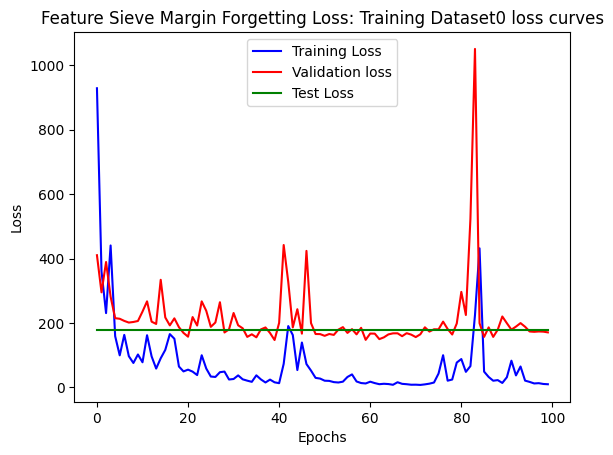

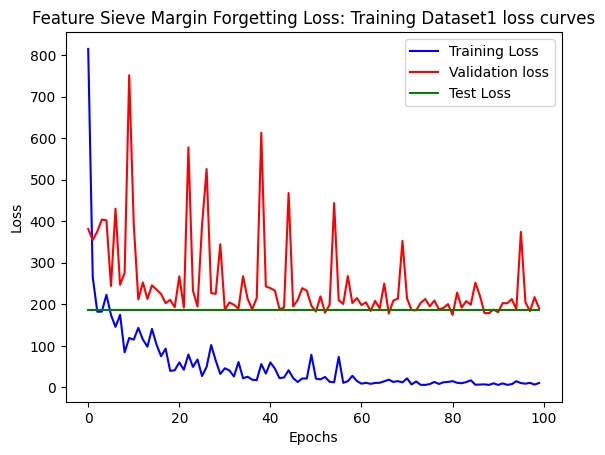

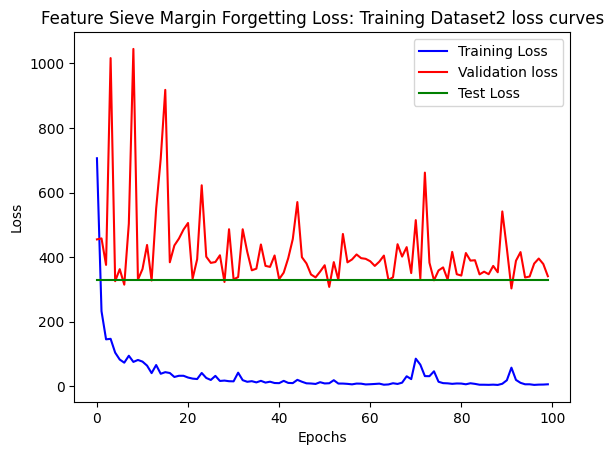

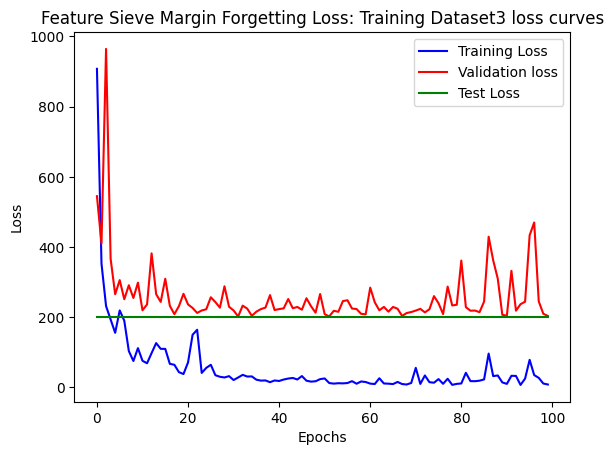

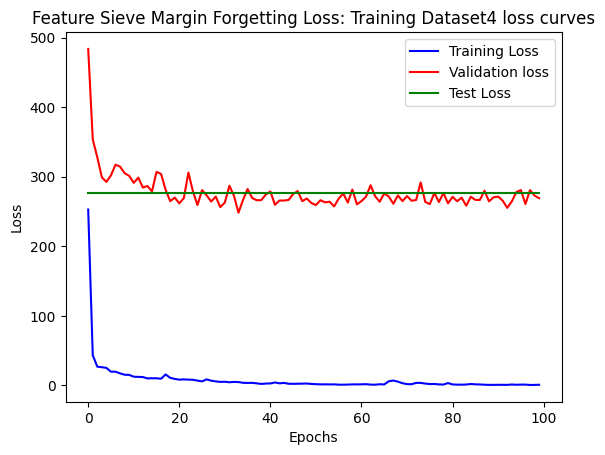

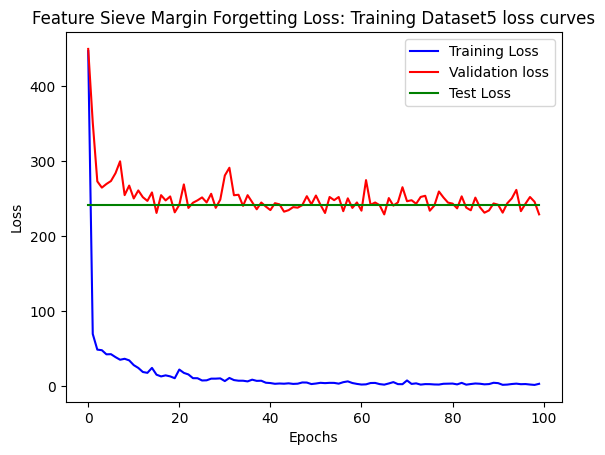

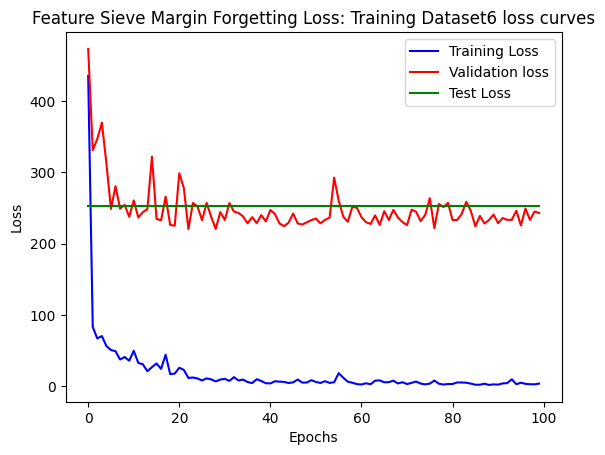

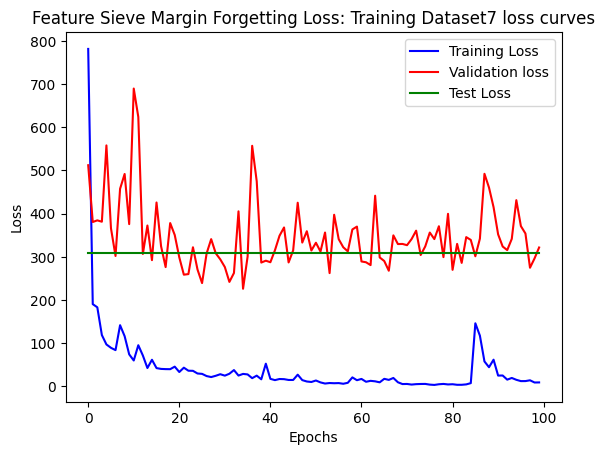

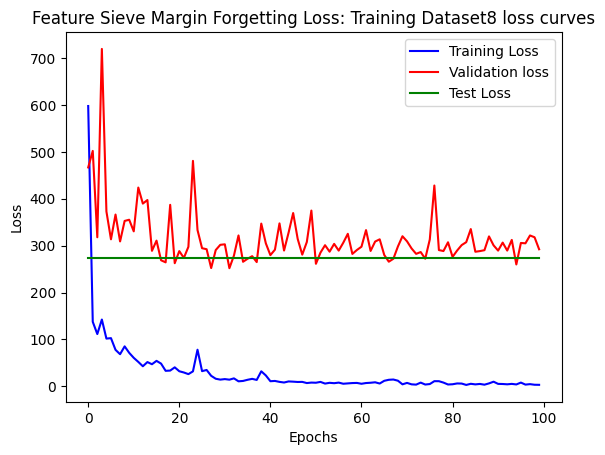

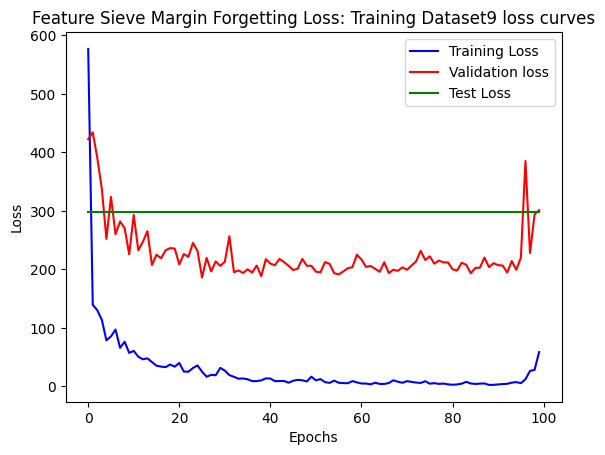

In [40]:
# plotting loss curves
for i in range(len(fs_tlosses)):
    plot_loss_curves(fs_tlosses[i], fs_vlosses[i], fs_tst_losses[i], epochs, model_name=f"Feature Sieve Margin Forgetting Loss: Training Dataset{i}")

In [41]:
full_fs_margin = fs_margin(1, False).to(device)
full_fs_margin, tloss, vloss = train_fs_mar(full_fs_margin, comp_train_dataloader, val_dataloader, margin=best_margin, forget_iters=best_forget_iter, lrs=[0.0005,0.0005,best_forget_lr], epochs=100, verbose=False)
full_fs_mar_tstloss = eval_FSModel(full_fs_margin, test_dataloader)

fs_tst_losses.insert(0,full_fs_mar_tstloss)
plot_loss_curves(tloss, vloss, full_fs_mar_tstloss, epochs=100, model_name="Feature Sieve Margin on Full Training Dataset")

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:59:32<00:00, 71.73s/it]


Test Loss: 72.8166275024414


TypeError: 'float' object cannot be interpreted as an integer

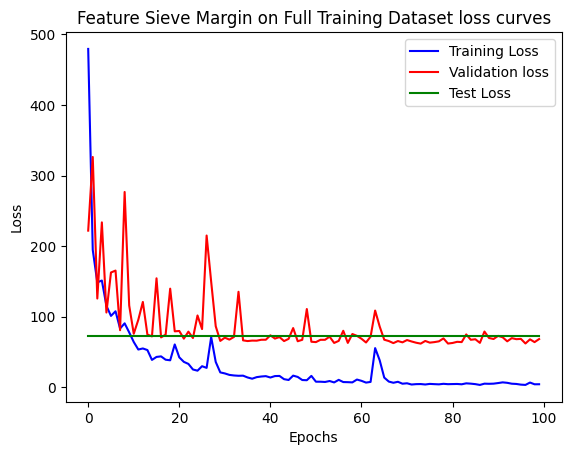

In [42]:
fs_tst_losses.insert(0,full_fs_mar_tstloss)
plot_loss_curves(tloss, vloss, full_fs_mar_tstloss, epochs=100, model_name="Feature Sieve Margin on Full Training Dataset")

## 2) Cross Entropy Forgetting Loss:

In [25]:
#Cross entropy model
class Feature_Sieve_CE(nn.Module):

    def __init__(self, block, layers, num_classes, num_bins, grayscale):
        self.num_classes = num_classes
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(Feature_Sieve_CE, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, 1)

        self.inplanes = 64
        self.auxlayer1 = self._make_layer(block, 128, layers[0])
        self.auxlayer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.aux_avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.aux_fc = nn.Linear(21632, num_bins)

        self.params = nn.ModuleDict({
            "main": nn.ModuleList([self.conv1, self.bn1, self.relu, self.maxpool, self.layer1, self.layer2, self.layer3, self.layer4, self.avgpool, self.fc]),
            "aux": nn.ModuleList([self.auxlayer1, self.auxlayer2, self.aux_avgpool, self.aux_fc]),
            "forget": nn.ModuleList([self.conv1, self.bn1, self.relu, self.maxpool])
        })

    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        sh = self.maxpool(x)
        x = self.layer1(sh)

        #forward of the main network
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        #forward of aux network
        aux = self.auxlayer1(sh)
        aux = self.auxlayer2(aux)
        aux = self.aux_avgpool(aux)
        aux = aux.view(aux.size(0), -1)
        aux = F.softmax(self.aux_fc(aux), dim=-1)

        return logits, aux

def fs_ce(num_classes, num_bins, grayscale):
    """Constructs a ResNet-34 model."""
    model = Feature_Sieve_CE(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   num_bins=num_bins,
                   grayscale=grayscale)
    return model
    

In [26]:
## Forgetting Loss: Cross Entropy
def learn_main_ce(FS, optim_main, x, y):
    FS.train()
    optim_main.zero_grad()
    out = FS(x)[0]
    loss = F.mse_loss(out, y)
    loss.backward()
    optim_main.step()
    optim_main.zero_grad()
    FS.eval()

def learn_aux_ce(FS, optim_main, optim_aux, x, y, bins, alpha_aux=1):
    FS.train()
    optim_main.zero_grad()
    aux = FS(x)[1]
    y = torch.bucketize(y,bins, right=False).reshape(-1)
    loss = alpha_aux * F.cross_entropy(aux, y)
    loss.backward()
    optim_aux.step()
    optim_aux.zero_grad()
    FS.eval()

def forget_aux_ce(FS, optim_forget, x, num_bins):
    FS.train()
    optim_forget.zero_grad()
    aux = FS(x)[1]
    loss = F.cross_entropy(aux, torch.ones_like(aux) * 1/num_bins)
    loss.backward()
    optim_forget.step()
    optim_forget.zero_grad()
    FS.eval()

In [27]:
#Functions
def train_fs_ce(model, train_dataloader, val_dataloader, age, num_bins = 20, epochs = 100, margin=10, aux_iters=1, main_iters=1, forget_iters=20, verbose=False, lrs=[0.0005, 0.0005, 0.0005], wds = [0,0,0]):
    if verbose:
        print("Training Model............")
    train_losses= []
    val_losses = []

    bin_counts, bin_edges = np.histogram(age, bins = num_bins -1 )
    bins = torch.tensor(bin_edges).to(device)
    
    optim_main = optim.Adam(model.params.main.parameters(),lr=lrs[0], weight_decay=wds[0])
    optim_aux = optim.Adam(model.params.aux.parameters(), lr=lrs[1], weight_decay=wds[1])
    optim_forget = optim.Adam(model.params.forget.parameters(), lr=lrs[2], weight_decay=wds[2])

    steps = 0

    for epoch in tqdm(range(epochs)):
        tloss = 0
        loss_num = 0

        for batch_idx, data in enumerate(train_dataloader):
            x,y = data
            x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)

            if main_iters and steps % main_iters == 0:
                learn_main_ce(model, optim_main, x, y)
            if aux_iters and steps % aux_iters == 0:
                learn_aux_ce(model, optim_main, optim_aux, x, y, bins)
            if forget_iters and steps % forget_iters == 0:
                forget_aux_ce(model, optim_forget, x, num_bins)

            with torch.no_grad():
                out = model(x)[0]
                loss = F.mse_loss(out, y)

                tloss += loss.detach().cpu()
                loss_num += 1
                steps += 1

        with torch.no_grad():
            vloss = 0
            vloss_num = 0
            
            for batch_idx, data in enumerate(val_dataloader):
                x,y = data
                x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)

                out = model(x)[0]
                loss = F.mse_loss(out, y)

                vloss += loss.detach().cpu()
                vloss_num += 1
                
        if verbose:
            print(f"Epochs: {epoch}/{epochs} Training Loss: {float(tloss / loss_num)} Validation Loss: {float(vloss / vloss_num)}")
            
        train_losses.append(float(tloss/ loss_num))
        val_losses.append(float(vloss / vloss_num))

    return model, train_losses, val_losses

In [23]:
#Training
epochs = 100
num_bins = 20
ages = data_df['age'].values

fs_ce_model = fs_ce(1, num_bins, False).to(device)
fs_ce_model, fs_ce_tloss, fs_ce_vloss = train_fs_ce(fs_ce_model, train_dataloaders[0], val_dataloader, ages, num_bins = num_bins, verbose = True)
fs_ce_test_loss = eval_FSModel(fs_ce_model, test_dataloader)

plot_loss_curves(fs_ce_tloss, fs_ce_vloss, fs_ce_test_loss, epochs = epochs, model_name = "Feature Sieve:Cross Entropy Forgetting Loss")

Training Model............


  0%|                                                                                                                                                 | 0/100 [00:18<?, ?it/s]


KeyboardInterrupt: 

In [46]:
#Hyperparameter tuning
num_bins = [3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
forget_lrs = [1e-5, 5e-4, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
forget_iters = [2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]

num_bin = 20

test_losses = []
for i in range(len(forget_iters)):
    print(f"Forget Iter: {forget_iters[i]}")
    model = fs_ce(1, num_bin, False).to(device)
    model, tloss, vloss = train_fs_ce(model, train_dataloaders[0], val_dataloader, ages,  num_bins=num_bin, forget_iters=forget_iters[i], epochs=5, verbose=False)
    tst_loss = eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)

best_forget_iter = forget_iters[test_losses.index(min(test_losses))]
print(f"Best Forget Iter: {best_forget_iter}")

test_losses = []
for i in range(len(forget_lrs)):
    print(f"Forget Lr: {forget_lrs[i]}")
    model = fs_ce(1, num_bin, False).to(device)
    model, tloss, vloss = train_fs_ce(model, train_dataloaders[0], val_dataloader, ages, num_bins=num_bin, forget_iters=best_forget_iter, lrs=[0.0005, 0.0005, forget_lrs[i]], epochs=5, verbose=False)
    tst_loss = eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)
best_forget_lr = forget_lrs[test_losses.index(min(test_losses))]
print(f"Best Forget Lr: {best_forget_lr}")

test_losses=[]
for i in range(len(num_bins)):
    print(f"Num Bins: {num_bins[i]}")
    model = fs_ce(1, num_bins[i], False).to(device)
    model, tloss, vloss = train_fs_ce(model, train_dataloaders[0], val_dataloader, ages, num_bins=num_bins[i], forget_iters=best_forget_iter, lrs=[0.0005,0.0005, best_forget_lr], epochs=5, verbose=False)
    tst_loss = eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)
best_num_bins = num_bins[test_losses.index(min(test_losses))]
print(f"Best Num Bins: {best_num_bins}")

Forget Iter: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:35<00:00, 31.09s/it]


Test Loss: 188.9726104736328
Forget Iter: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:56<00:00, 35.36s/it]


Test Loss: 209.47503662109375
Forget Iter: 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:58<00:00, 35.64s/it]


Test Loss: 295.4831237792969
Forget Iter: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:57<00:00, 35.43s/it]


Test Loss: 273.8879089355469
Forget Iter: 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:54<00:00, 34.85s/it]


Test Loss: 340.2899475097656
Forget Iter: 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:56<00:00, 35.39s/it]


Test Loss: 1260.3504638671875
Forget Iter: 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:54<00:00, 34.83s/it]


Test Loss: 203.2891387939453
Forget Iter: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:54<00:00, 34.96s/it]


Test Loss: 270.7403564453125
Forget Iter: 70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:55<00:00, 35.17s/it]


Test Loss: 218.1846923828125
Forget Iter: 80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:55<00:00, 35.13s/it]


Test Loss: 1014.4155883789062
Forget Iter: 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:55<00:00, 35.03s/it]


Test Loss: 265.92352294921875
Forget Iter: 100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:55<00:00, 35.09s/it]


Test Loss: 561.5079956054688
Forget Iter: 200


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:58<00:00, 35.62s/it]


Test Loss: 199.1851806640625
Best Forget Iter: 2
Forget Lr: 1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:11<00:00, 38.30s/it]


Test Loss: 304.4369812011719
Forget Lr: 0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:13<00:00, 38.79s/it]


Test Loss: 196.960693359375
Forget Lr: 0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:10<00:00, 38.16s/it]


Test Loss: 477.94732666015625
Forget Lr: 0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:07<00:00, 37.42s/it]


Test Loss: 593.125244140625
Forget Lr: 0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [03:01<00:00, 36.36s/it]


Test Loss: 227.2938690185547
Forget Lr: 0.01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:58<00:00, 35.64s/it]


Test Loss: 226.6198272705078
Forget Lr: 0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:57<00:00, 35.53s/it]


Test Loss: 204.45501708984375
Forget Lr: 0.1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:54<00:00, 34.89s/it]


Test Loss: 189.7186737060547
Best Forget Lr: 0.1
Num Bins: 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:45<00:00, 33.12s/it]


Test Loss: 301.1495361328125
Num Bins: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:47<00:00, 33.43s/it]


Test Loss: 224.38694763183594
Num Bins: 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:51<00:00, 34.22s/it]


Test Loss: 321.97607421875
Num Bins: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:50<00:00, 34.02s/it]


Test Loss: 211.0284423828125
Num Bins: 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:53<00:00, 34.63s/it]


Test Loss: 247.28042602539062
Num Bins: 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:51<00:00, 34.28s/it]


Test Loss: 235.97201538085938
Num Bins: 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:52<00:00, 34.46s/it]


Test Loss: 307.9757385253906
Num Bins: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:51<00:00, 34.26s/it]


Test Loss: 287.79913330078125
Num Bins: 70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:55<00:00, 35.05s/it]


Test Loss: 339.7842712402344
Num Bins: 80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:57<00:00, 35.55s/it]


Test Loss: 204.39402770996094
Num Bins: 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:54<00:00, 34.84s/it]


Test Loss: 243.2328338623047
Num Bins: 100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:54<00:00, 34.97s/it]


Test Loss: 270.8900451660156
Best Num Bins: 80


In [47]:
fs_ce_tloss = []
fs_ce_vloss = []
fs_ce_test_loss = []

best_num_bins = 3
best_forget_iters = 50 
best_forget_lr = 0.001

for i in range(len(train_dataloaders)):
    print(f"Training Dataset {i}")
    model = fs_ce(1, best_num_bins, False).to(device)
    model, fs_ce_loss, fs_ce_val_loss = train_fs_ce(model, train_dataloaders[i], val_dataloader, ages, num_bins = best_num_bins, forget_iters=best_forget_iters, lrs=[0.0005, 0.0005, best_forget_lr], verbose = False)
    fs_ce_tst_loss = eval_FSModel(model, test_dataloader)

    fs_ce_tloss.append(fs_ce_loss)
    fs_ce_vloss.append(fs_ce_val_loss)
    fs_ce_test_loss.append(fs_ce_tst_loss)

    torch.save(model.state_dict(), f"./Models/fs_ce_model{i}.pth")
    print(f"Logged model into: ./Models/fs_ce_model{i}.pth")

Training Dataset 0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [52:04<00:00, 31.24s/it]


Test Loss: 174.06626892089844
Logged model into: ./Models/fs_ce_model0.pth
Training Dataset 1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [54:18<00:00, 32.58s/it]


Test Loss: 224.8866729736328
Logged model into: ./Models/fs_ce_model1.pth
Training Dataset 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [55:20<00:00, 33.21s/it]


Test Loss: 304.33721923828125
Logged model into: ./Models/fs_ce_model2.pth
Training Dataset 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [55:30<00:00, 33.31s/it]


Test Loss: 219.54811096191406
Logged model into: ./Models/fs_ce_model3.pth
Training Dataset 4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [55:24<00:00, 33.25s/it]


Test Loss: 266.0223388671875
Logged model into: ./Models/fs_ce_model4.pth
Training Dataset 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [55:56<00:00, 33.56s/it]


Test Loss: 235.9572296142578
Logged model into: ./Models/fs_ce_model5.pth
Training Dataset 6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [55:48<00:00, 33.48s/it]


Test Loss: 234.09063720703125
Logged model into: ./Models/fs_ce_model6.pth
Training Dataset 7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [56:12<00:00, 33.73s/it]


Test Loss: 368.1534423828125
Logged model into: ./Models/fs_ce_model7.pth
Training Dataset 8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [55:55<00:00, 33.56s/it]


Test Loss: 278.2205810546875
Logged model into: ./Models/fs_ce_model8.pth
Training Dataset 9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [56:08<00:00, 33.68s/it]


Test Loss: 207.40386962890625
Logged model into: ./Models/fs_ce_model9.pth


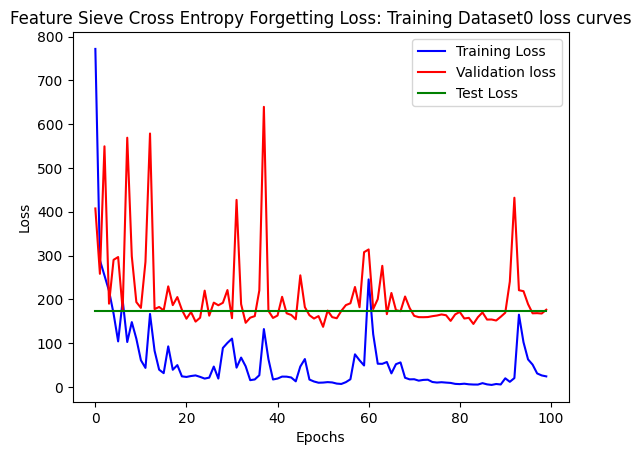

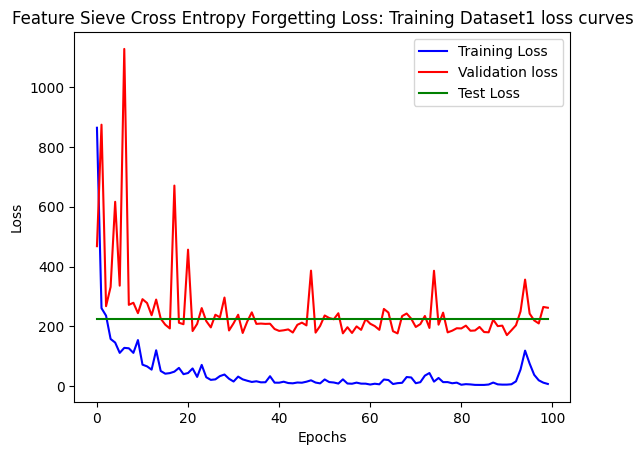

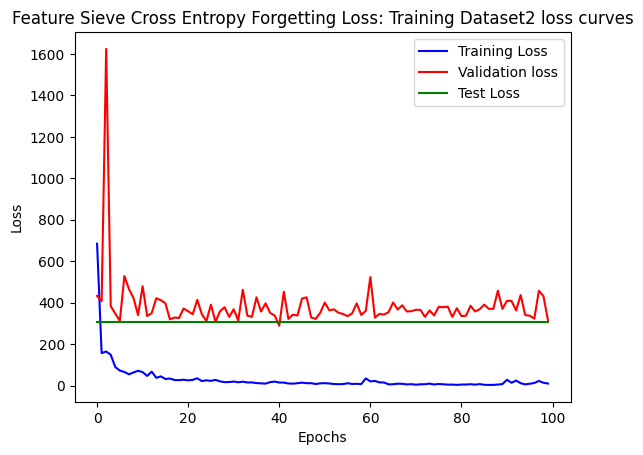

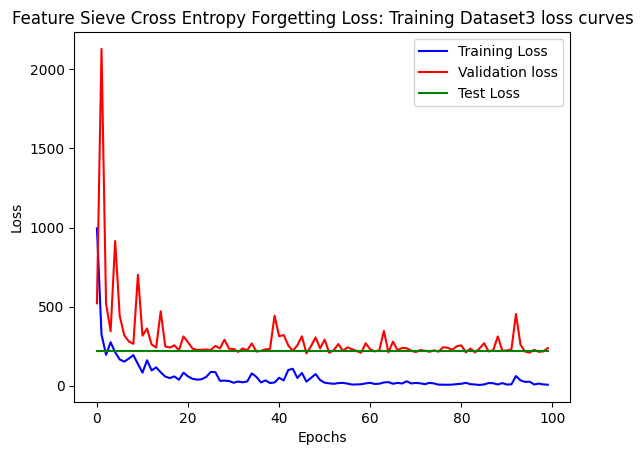

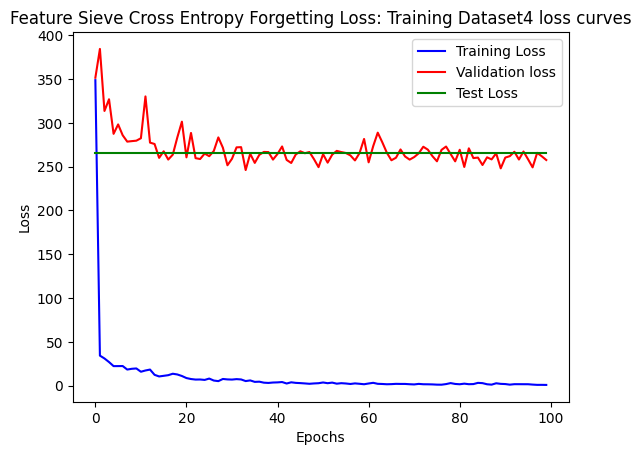

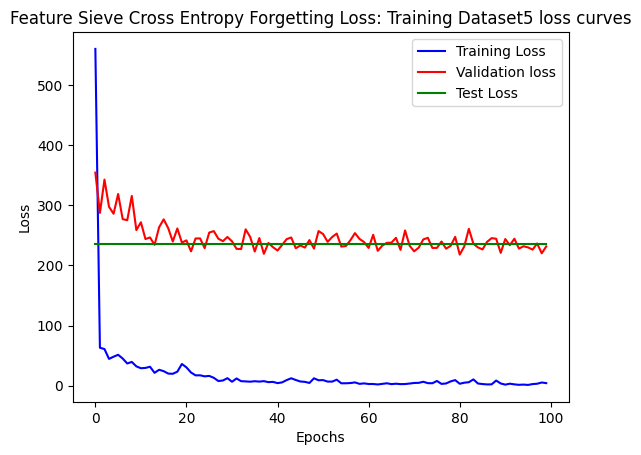

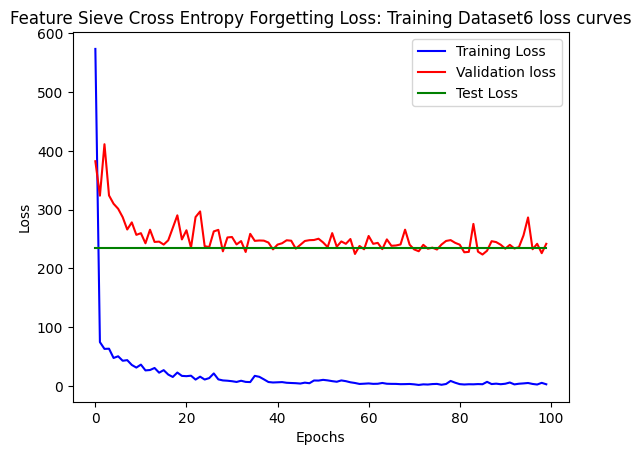

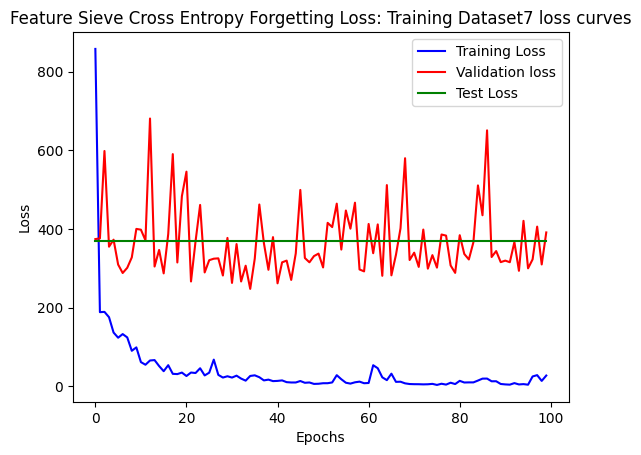

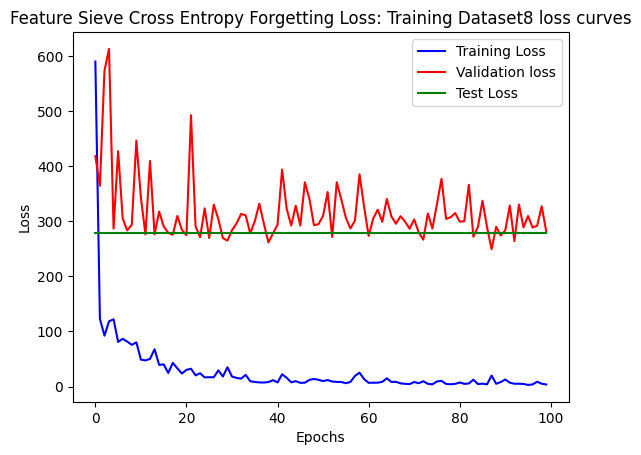

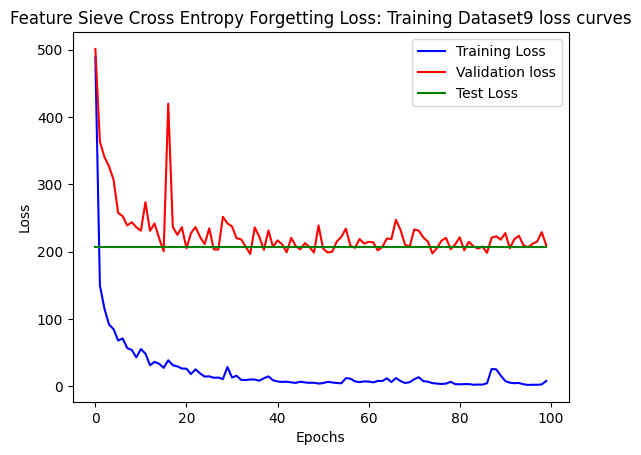

In [48]:
for i in range(len(fs_ce_tloss)):
    plot_loss_curves(fs_ce_tloss[i], fs_ce_vloss[i], fs_ce_test_loss[i], epochs= 100, model_name= "Feature Sieve Cross Entropy Forgetting Loss: Training Dataset{}".format(i))

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [2:18:31<00:00, 83.11s/it]


Test Loss: 69.14472198486328


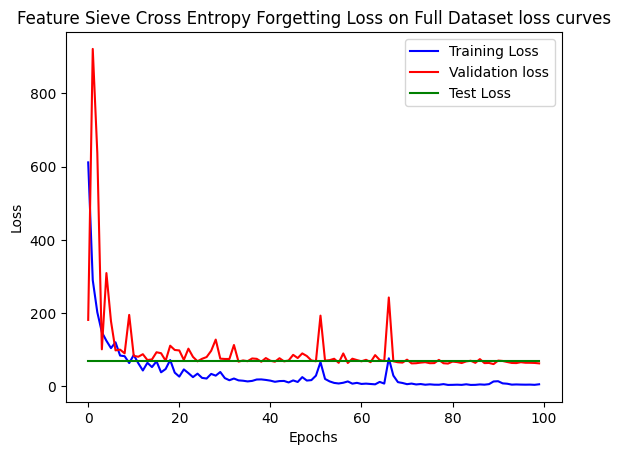

In [52]:
comp_fs_ce = fs_ce(1, best_num_bins, False).to(device)
comp_fs_ce, tloss, vloss = train_fs_ce(comp_fs_ce, comp_train_dataloader, val_dataloader, ages, num_bins=best_num_bins, epochs=100, forget_iters=best_forget_iters, lrs=[0.0005,0.0005,best_forget_lr], verbose=False)
comp_tst_loss = eval_FSModel(comp_fs_ce, test_dataloader)
fs_ce_test_loss.insert(0, comp_tst_loss)

plot_loss_curves(tloss, vloss, comp_tst_loss, epochs=100, model_name="Feature Sieve Cross Entropy Forgetting Loss on Full Dataset")

## 3) Ordinal Forgetting Loss

In [28]:
# Ordinal Model
class Feature_Sieve_Ord(nn.Module):

    def __init__(self, block, layers, num_classes, num_bins, grayscale):
        self.num_classes = num_classes
        self.inplanes = 64
        if grayscale:
            in_dim = 1
        else:
            in_dim = 3
        super(Feature_Sieve_Ord, self).__init__()
        self.conv1 = nn.Conv2d(in_dim, 64, kernel_size=7, stride=2, padding=3,
                               bias=False)
        self.bn1 = nn.BatchNorm2d(64)
        self.relu = nn.ReLU(inplace=True)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)
        self.layer1 = self._make_layer(block, 64, layers[0])
        self.layer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.layer3 = self._make_layer(block, 256, layers[2], stride=2)
        self.layer4 = self._make_layer(block, 512, layers[3], stride=2)
        self.avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.fc = nn.Linear(2048 * block.expansion, 1)

        self.inplanes = 64
        self.auxlayer1 = self._make_layer(block, 64, layers[0])
        self.auxlayer2 = self._make_layer(block, 128, layers[1], stride=2)
        self.aux_avgpool = nn.AvgPool2d(7, stride=1, padding=2)
        self.aux_fc = nn.Linear(21632, num_bins)

        self.params = nn.ModuleDict({
            "main": nn.ModuleList([self.conv1, self.bn1, self.relu, self.maxpool, self.layer1, self.layer2, self.layer3, self.layer4, self.avgpool, self.fc]),
            "aux": nn.ModuleList([self.auxlayer1, self.auxlayer2, self.aux_avgpool, self.aux_fc]),
            "forget": nn.ModuleList([self.conv1, self.bn1, self.relu, self.maxpool])
        })

    
        for m in self.modules():
            if isinstance(m, nn.Conv2d):
                n = m.kernel_size[0] * m.kernel_size[1] * m.out_channels
                m.weight.data.normal_(0, (2. / n)**.5)
            elif isinstance(m, nn.BatchNorm2d):
                m.weight.data.fill_(1)
                m.bias.data.zero_()
        
    def _make_layer(self, block, planes, blocks, stride=1):
        downsample = None
        if stride != 1 or self.inplanes != planes * block.expansion:
            downsample = nn.Sequential(
                nn.Conv2d(self.inplanes, planes * block.expansion,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(planes * block.expansion),
            )

        layers = []
        layers.append(block(self.inplanes, planes, stride, downsample))
        self.inplanes = planes * block.expansion
        for i in range(1, blocks):
            layers.append(block(self.inplanes, planes))

        return nn.Sequential(*layers)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        sh = self.maxpool(x)

        #forward of the main network
        x = self.layer1(sh)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        logits = self.fc(x)

        #forward of aux network
        aux = self.auxlayer1(sh)
        aux = self.auxlayer2(aux)
        aux = self.aux_avgpool(aux)
        aux = aux.view(aux.size(0), -1)
        aux = self.aux_fc(aux)
        
        return logits, aux

def fs_ord(num_classes,num_bins, grayscale):
    """Constructs a ResNet-34 model."""
    model = Feature_Sieve_Ord(block=BasicBlock,
                   layers=[3, 4, 6, 3],
                   num_classes=num_classes,
                   num_bins=num_bins,
                   grayscale=grayscale)
    return model

In [29]:
# Multilabel Loss function
multi_label_loss = nn.BCEWithLogitsLoss()

def learn_main_ordinal(model, optim_main,x, y):
    model.train()
    optim_main.zero_grad()
    out = model(x)[0]
    loss = F.mse_loss(out, y)
    loss.backward()
    optim_main.step()
    optim_main.zero_grad()
    model.eval()


def learn_aux_ordinal(model, optim_main, optim_aux, x, y_ord, alpha_aux=1):
    model.train()
    optim_main.zero_grad()
    aux = model(x)[1]
    loss = alpha_aux * multi_label_loss(aux, y_ord)
    loss.backward()
    optim_aux.step()
    optim_aux.zero_grad()
    model.eval()

def forget_aux_ordinal(model, optim_forget, x,y, num_bins):
    model.train()
    optim_forget.zero_grad()
    aux = model(x)[1]
    aux_preds = torch.sum(F.sigmoid(aux), dim =-1) * 116 / num_bins
    loss = F.mse_loss(aux_preds.reshape(-1,1), y)
    loss.backward()
    optim_forget.step()
    optim_forget.zero_grad()
    model.eval()

In [30]:
#Functions
def train_fs_ord(model, train_dataloader, val_dataloader, num_bins=20, epochs = 100, margin=10, aux_iters=1, main_iters=1, forget_iters=10, verbose=False, lrs=[0.0005, 0.0005, 0.0005], wds = [0,0,0]):
    train_losses= []
    val_losses = []
    
    optim_main = optim.Adam(model.params.main.parameters(),lr=lrs[0], weight_decay=wds[0])
    optim_aux = optim.Adam(model.params.aux.parameters(), lr=lrs[1], weight_decay=wds[1])
    optim_forget = optim.Adam(model.params.forget.parameters(), lr=lrs[2], weight_decay=wds[2])

    steps = 0

    for epoch in tqdm(range(epochs)):
        tloss = 0
        loss_num = 0

        for batch_idx, data in enumerate(train_dataloader):
            x,y = data
            y_ord = y.reshape(-1).numpy()
            x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)

            #Ordinal label generation
            y_ord = np.greater_equal.outer(y_ord, np.arange(num_bins)*116/num_bins).astype(float)
            y_ord = torch.tensor(y_ord).reshape(y_ord.shape[0], -1).to(torch.float32).to(device)

            if main_iters and steps % main_iters == 0:
                learn_main_ordinal(model, optim_main, x, y)
            if aux_iters and steps % aux_iters == 0:
                learn_aux_ordinal(model, optim_main, optim_aux, x, y_ord)
            if forget_iters and steps % forget_iters == 0:
                forget_aux_ordinal(model, optim_forget, x, y, num_bins)

            with torch.no_grad():
                out = model(x)[0]
                loss = F.mse_loss(out, y)

                tloss += loss.detach().cpu()
                loss_num += 1
                steps += 1

        with torch.no_grad():
            vloss = 0
            vloss_num = 0
            
            for batch_idx, data in enumerate(val_dataloader):
                x,y = data
                x,y = x.to(torch.float32).to(device), y.reshape(y.shape[0], 1).to(torch.float32).to(device)

                out = model(x)[0]
                loss = F.mse_loss(out, y)

                vloss += loss.detach().cpu()
                vloss_num += 1
                
        if verbose:
            print(f"Epochs: {epoch}/{epochs} Training Loss: {float(tloss / loss_num)} Validation Loss: {float(vloss / vloss_num)}")
            
        train_losses.append(float(tloss/ loss_num))
        val_losses.append(float(vloss / vloss_num))

    return model, train_losses, val_losses

In [57]:
fs_ord_model = fs_ord(1, 20, False).to(device)
fs_ord_model, fs_ord_tloss, fs_ord_vloss = train_fs_ord(fs_ord_model, train_dataloaders[0], val_dataloader, num_bins = 20, verbose = True)
fs_ord_tst_loss = eval_FSModel(fs_ord_model, test_dataloader)

  1%|█▌                                                                                                                                                           | 1/100 [00:24<40:05, 24.30s/it]

Epochs: 0/100 Training Loss: 762.115234375 Validation Loss: 504.7810974121094


  2%|███▏                                                                                                                                                         | 2/100 [00:48<39:45, 24.34s/it]

Epochs: 1/100 Training Loss: 391.04144287109375 Validation Loss: 1033.943603515625


  3%|████▋                                                                                                                                                        | 3/100 [01:13<39:27, 24.41s/it]

Epochs: 2/100 Training Loss: 244.74618530273438 Validation Loss: 711.0027465820312


  4%|██████▎                                                                                                                                                      | 4/100 [01:38<39:22, 24.61s/it]

Epochs: 3/100 Training Loss: 184.27369689941406 Validation Loss: 203.33895874023438


  5%|███████▊                                                                                                                                                     | 5/100 [02:03<39:30, 24.95s/it]

Epochs: 4/100 Training Loss: 180.07591247558594 Validation Loss: 202.0953369140625


  6%|█████████▍                                                                                                                                                   | 6/100 [02:29<39:30, 25.21s/it]

Epochs: 5/100 Training Loss: 146.49635314941406 Validation Loss: 231.95582580566406


  7%|██████████▉                                                                                                                                                  | 7/100 [02:55<39:41, 25.61s/it]

Epochs: 6/100 Training Loss: 165.55685424804688 Validation Loss: 938.7444458007812


  8%|████████████▌                                                                                                                                                | 8/100 [03:23<40:04, 26.14s/it]

Epochs: 7/100 Training Loss: 76.48080444335938 Validation Loss: 219.92092895507812


  9%|██████████████▏                                                                                                                                              | 9/100 [03:50<40:01, 26.39s/it]

Epochs: 8/100 Training Loss: 204.6811065673828 Validation Loss: 258.3948059082031


 10%|███████████████▌                                                                                                                                            | 10/100 [04:18<40:26, 26.97s/it]

Epochs: 9/100 Training Loss: 68.05195617675781 Validation Loss: 414.63165283203125


 11%|█████████████████▏                                                                                                                                          | 11/100 [04:47<40:49, 27.53s/it]

Epochs: 10/100 Training Loss: 101.41038513183594 Validation Loss: 176.3054656982422


 12%|██████████████████▋                                                                                                                                         | 12/100 [05:17<41:44, 28.46s/it]

Epochs: 11/100 Training Loss: 67.75041198730469 Validation Loss: 317.26519775390625


 13%|████████████████████▎                                                                                                                                       | 13/100 [05:45<41:01, 28.29s/it]

Epochs: 12/100 Training Loss: 74.7796859741211 Validation Loss: 217.3369903564453


 14%|█████████████████████▊                                                                                                                                      | 14/100 [06:14<40:40, 28.38s/it]

Epochs: 13/100 Training Loss: 65.23625183105469 Validation Loss: 197.40493774414062


 15%|███████████████████████▍                                                                                                                                    | 15/100 [06:43<40:33, 28.63s/it]

Epochs: 14/100 Training Loss: 48.42184066772461 Validation Loss: 171.88235473632812


 16%|████████████████████████▉                                                                                                                                   | 16/100 [07:11<39:41, 28.35s/it]

Epochs: 15/100 Training Loss: 64.30699157714844 Validation Loss: 211.734375


 17%|██████████████████████████▌                                                                                                                                 | 17/100 [07:42<40:20, 29.16s/it]

Epochs: 16/100 Training Loss: 44.97589874267578 Validation Loss: 244.3905487060547


 18%|████████████████████████████                                                                                                                                | 18/100 [08:09<39:07, 28.63s/it]

Epochs: 17/100 Training Loss: 91.35445404052734 Validation Loss: 638.3914184570312


 19%|█████████████████████████████▋                                                                                                                              | 19/100 [08:38<38:45, 28.72s/it]

Epochs: 18/100 Training Loss: 167.53721618652344 Validation Loss: 625.6107177734375


 20%|███████████████████████████████▏                                                                                                                            | 20/100 [09:07<38:19, 28.75s/it]

Epochs: 19/100 Training Loss: 100.16520690917969 Validation Loss: 682.8742065429688


 21%|████████████████████████████████▊                                                                                                                           | 21/100 [09:35<37:32, 28.52s/it]

Epochs: 20/100 Training Loss: 66.3234634399414 Validation Loss: 224.0659942626953


 22%|██████████████████████████████████▎                                                                                                                         | 22/100 [10:04<37:12, 28.63s/it]

Epochs: 21/100 Training Loss: 44.55152130126953 Validation Loss: 214.10987854003906


 23%|███████████████████████████████████▉                                                                                                                        | 23/100 [10:31<36:26, 28.39s/it]

Epochs: 22/100 Training Loss: 52.7200813293457 Validation Loss: 163.85047912597656


 24%|█████████████████████████████████████▍                                                                                                                      | 24/100 [11:02<36:39, 28.94s/it]

Epochs: 23/100 Training Loss: 57.327613830566406 Validation Loss: 406.355224609375


 25%|███████████████████████████████████████                                                                                                                     | 25/100 [11:30<35:58, 28.78s/it]

Epochs: 24/100 Training Loss: 24.47012710571289 Validation Loss: 191.14639282226562


 26%|████████████████████████████████████████▌                                                                                                                   | 26/100 [11:58<35:20, 28.66s/it]

Epochs: 25/100 Training Loss: 29.198450088500977 Validation Loss: 161.62277221679688


 27%|██████████████████████████████████████████                                                                                                                  | 27/100 [12:28<35:02, 28.81s/it]

Epochs: 26/100 Training Loss: 27.168176651000977 Validation Loss: 165.4730987548828


 28%|███████████████████████████████████████████▋                                                                                                                | 28/100 [12:57<34:58, 29.14s/it]

Epochs: 27/100 Training Loss: 27.911596298217773 Validation Loss: 191.1405029296875


 29%|█████████████████████████████████████████████▏                                                                                                              | 29/100 [13:28<34:48, 29.41s/it]

Epochs: 28/100 Training Loss: 23.062185287475586 Validation Loss: 165.92556762695312


 30%|██████████████████████████████████████████████▊                                                                                                             | 30/100 [13:56<34:04, 29.21s/it]

Epochs: 29/100 Training Loss: 26.87528419494629 Validation Loss: 158.32728576660156


 31%|████████████████████████████████████████████████▎                                                                                                           | 31/100 [14:25<33:22, 29.03s/it]

Epochs: 30/100 Training Loss: 30.24700355529785 Validation Loss: 232.92300415039062


 32%|█████████████████████████████████████████████████▉                                                                                                          | 32/100 [14:54<32:56, 29.07s/it]

Epochs: 31/100 Training Loss: 36.93096160888672 Validation Loss: 306.74639892578125


 33%|███████████████████████████████████████████████████▍                                                                                                        | 33/100 [15:23<32:34, 29.18s/it]

Epochs: 32/100 Training Loss: 37.49064636230469 Validation Loss: 191.48231506347656


 34%|█████████████████████████████████████████████████████                                                                                                       | 34/100 [15:53<32:05, 29.17s/it]

Epochs: 33/100 Training Loss: 22.04412269592285 Validation Loss: 174.64210510253906


 35%|██████████████████████████████████████████████████████▌                                                                                                     | 35/100 [16:24<32:13, 29.75s/it]

Epochs: 34/100 Training Loss: 21.145193099975586 Validation Loss: 174.63632202148438


 36%|████████████████████████████████████████████████████████▏                                                                                                   | 36/100 [16:52<31:22, 29.41s/it]

Epochs: 35/100 Training Loss: 22.69948387145996 Validation Loss: 162.1094512939453


 37%|█████████████████████████████████████████████████████████▋                                                                                                  | 37/100 [17:22<30:49, 29.35s/it]

Epochs: 36/100 Training Loss: 29.01936912536621 Validation Loss: 263.4352722167969


 38%|███████████████████████████████████████████████████████████▎                                                                                                | 38/100 [17:49<29:48, 28.84s/it]

Epochs: 37/100 Training Loss: 23.078670501708984 Validation Loss: 313.4248352050781


 39%|████████████████████████████████████████████████████████████▊                                                                                               | 39/100 [18:20<29:47, 29.30s/it]

Epochs: 38/100 Training Loss: 83.69153594970703 Validation Loss: 178.35464477539062


 40%|██████████████████████████████████████████████████████████████▍                                                                                             | 40/100 [18:49<29:26, 29.45s/it]

Epochs: 39/100 Training Loss: 45.69047164916992 Validation Loss: 200.39479064941406


 41%|███████████████████████████████████████████████████████████████▉                                                                                            | 41/100 [19:19<29:01, 29.52s/it]

Epochs: 40/100 Training Loss: 22.45809555053711 Validation Loss: 176.3809814453125


 42%|█████████████████████████████████████████████████████████████████▌                                                                                          | 42/100 [19:48<28:29, 29.47s/it]

Epochs: 41/100 Training Loss: 27.333454132080078 Validation Loss: 185.7216339111328


 43%|███████████████████████████████████████████████████████████████████                                                                                         | 43/100 [20:19<28:26, 29.94s/it]

Epochs: 42/100 Training Loss: 16.276708602905273 Validation Loss: 178.45774841308594


 44%|████████████████████████████████████████████████████████████████████▋                                                                                       | 44/100 [20:48<27:38, 29.62s/it]

Epochs: 43/100 Training Loss: 16.48154067993164 Validation Loss: 183.2425079345703


 45%|██████████████████████████████████████████████████████████████████████▏                                                                                     | 45/100 [21:19<27:25, 29.92s/it]

Epochs: 44/100 Training Loss: 14.496522903442383 Validation Loss: 186.19558715820312


 46%|███████████████████████████████████████████████████████████████████████▊                                                                                    | 46/100 [21:48<26:42, 29.67s/it]

Epochs: 45/100 Training Loss: 11.85699462890625 Validation Loss: 165.93966674804688


 47%|█████████████████████████████████████████████████████████████████████████▎                                                                                  | 47/100 [22:17<25:55, 29.36s/it]

Epochs: 46/100 Training Loss: 24.359216690063477 Validation Loss: 263.7861022949219


 48%|██████████████████████████████████████████████████████████████████████████▉                                                                                 | 48/100 [22:44<25:01, 28.88s/it]

Epochs: 47/100 Training Loss: 14.415651321411133 Validation Loss: 249.13198852539062


 49%|████████████████████████████████████████████████████████████████████████████▍                                                                               | 49/100 [23:14<24:45, 29.13s/it]

Epochs: 48/100 Training Loss: 34.86836242675781 Validation Loss: 187.954833984375


 50%|██████████████████████████████████████████████████████████████████████████████                                                                              | 50/100 [23:44<24:23, 29.27s/it]

Epochs: 49/100 Training Loss: 24.05730628967285 Validation Loss: 172.8611297607422


 51%|███████████████████████████████████████████████████████████████████████████████▌                                                                            | 51/100 [24:12<23:35, 28.89s/it]

Epochs: 50/100 Training Loss: 29.171649932861328 Validation Loss: 169.9859161376953


 52%|█████████████████████████████████████████████████████████████████████████████████                                                                           | 52/100 [24:41<23:14, 29.05s/it]

Epochs: 51/100 Training Loss: 24.80233383178711 Validation Loss: 419.0442199707031


 53%|██████████████████████████████████████████████████████████████████████████████████▋                                                                         | 53/100 [25:10<22:41, 28.97s/it]

Epochs: 52/100 Training Loss: 22.04972267150879 Validation Loss: 179.51499938964844


 54%|████████████████████████████████████████████████████████████████████████████████████▏                                                                       | 54/100 [25:39<22:15, 29.03s/it]

Epochs: 53/100 Training Loss: 144.57664489746094 Validation Loss: 226.61422729492188


 55%|█████████████████████████████████████████████████████████████████████████████████████▊                                                                      | 55/100 [26:07<21:34, 28.78s/it]

Epochs: 54/100 Training Loss: 134.04052734375 Validation Loss: 202.9665985107422


 56%|███████████████████████████████████████████████████████████████████████████████████████▎                                                                    | 56/100 [26:36<21:05, 28.77s/it]

Epochs: 55/100 Training Loss: 53.02031326293945 Validation Loss: 231.86459350585938


 57%|████████████████████████████████████████████████████████████████████████████████████████▉                                                                   | 57/100 [27:05<20:45, 28.97s/it]

Epochs: 56/100 Training Loss: 26.6003360748291 Validation Loss: 162.582763671875


 58%|██████████████████████████████████████████████████████████████████████████████████████████▍                                                                 | 58/100 [27:36<20:32, 29.34s/it]

Epochs: 57/100 Training Loss: 48.72477340698242 Validation Loss: 219.12823486328125


 59%|████████████████████████████████████████████████████████████████████████████████████████████                                                                | 59/100 [28:04<19:47, 28.97s/it]

Epochs: 58/100 Training Loss: 16.88250732421875 Validation Loss: 148.94244384765625


 60%|█████████████████████████████████████████████████████████████████████████████████████████████▌                                                              | 60/100 [28:33<19:22, 29.06s/it]

Epochs: 59/100 Training Loss: 14.049842834472656 Validation Loss: 168.3957977294922


 61%|███████████████████████████████████████████████████████████████████████████████████████████████▏                                                            | 61/100 [29:03<19:08, 29.46s/it]

Epochs: 60/100 Training Loss: 18.353015899658203 Validation Loss: 161.6992645263672


 62%|████████████████████████████████████████████████████████████████████████████████████████████████▋                                                           | 62/100 [29:32<18:32, 29.29s/it]

Epochs: 61/100 Training Loss: 12.80711555480957 Validation Loss: 173.4449005126953


 63%|██████████████████████████████████████████████████████████████████████████████████████████████████▎                                                         | 63/100 [30:00<17:49, 28.90s/it]

Epochs: 62/100 Training Loss: 10.832853317260742 Validation Loss: 189.43560791015625


 64%|███████████████████████████████████████████████████████████████████████████████████████████████████▊                                                        | 64/100 [30:29<17:21, 28.94s/it]

Epochs: 63/100 Training Loss: 10.591558456420898 Validation Loss: 158.798828125


 65%|█████████████████████████████████████████████████████████████████████████████████████████████████████▍                                                      | 65/100 [30:59<16:58, 29.11s/it]

Epochs: 64/100 Training Loss: 8.404211044311523 Validation Loss: 162.56912231445312


 66%|██████████████████████████████████████████████████████████████████████████████████████████████████████▉                                                     | 66/100 [31:28<16:33, 29.22s/it]

Epochs: 65/100 Training Loss: 8.185606002807617 Validation Loss: 161.69308471679688


 67%|████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                   | 67/100 [31:57<16:00, 29.10s/it]

Epochs: 66/100 Training Loss: 8.112020492553711 Validation Loss: 159.6102294921875


 68%|██████████████████████████████████████████████████████████████████████████████████████████████████████████                                                  | 68/100 [32:27<15:35, 29.24s/it]

Epochs: 67/100 Training Loss: 9.540528297424316 Validation Loss: 166.8715362548828


 69%|███████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                                | 69/100 [32:56<15:09, 29.34s/it]

Epochs: 68/100 Training Loss: 8.164541244506836 Validation Loss: 158.9555206298828


 70%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                              | 70/100 [33:25<14:30, 29.00s/it]

Epochs: 69/100 Training Loss: 48.728912353515625 Validation Loss: 155.35659790039062


 71%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                                             | 71/100 [33:54<14:03, 29.08s/it]

Epochs: 70/100 Training Loss: 17.18727684020996 Validation Loss: 174.79916381835938


 72%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                                           | 72/100 [34:23<13:34, 29.10s/it]

Epochs: 71/100 Training Loss: 12.005990982055664 Validation Loss: 174.59129333496094


 73%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                                          | 73/100 [34:53<13:13, 29.37s/it]

Epochs: 72/100 Training Loss: 9.743314743041992 Validation Loss: 189.2539825439453


 74%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                                        | 74/100 [35:23<12:52, 29.71s/it]

Epochs: 73/100 Training Loss: 56.53667449951172 Validation Loss: 187.8155517578125


 75%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                       | 75/100 [35:51<12:06, 29.05s/it]

Epochs: 74/100 Training Loss: 16.00594711303711 Validation Loss: 215.14141845703125


 76%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                     | 76/100 [36:21<11:47, 29.48s/it]

Epochs: 75/100 Training Loss: 23.216564178466797 Validation Loss: 202.29237365722656


 77%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                                    | 77/100 [36:50<11:10, 29.17s/it]

Epochs: 76/100 Training Loss: 12.796897888183594 Validation Loss: 210.3111572265625


 78%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                                  | 78/100 [37:20<10:51, 29.60s/it]

Epochs: 77/100 Training Loss: 15.756311416625977 Validation Loss: 168.95150756835938


 79%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                                | 79/100 [37:48<10:08, 28.97s/it]

Epochs: 78/100 Training Loss: 8.567538261413574 Validation Loss: 156.57687377929688


 80%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                               | 80/100 [38:18<09:46, 29.35s/it]

Epochs: 79/100 Training Loss: 6.9985246658325195 Validation Loss: 179.4984130859375


 81%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                             | 81/100 [38:47<09:12, 29.10s/it]

Epochs: 80/100 Training Loss: 8.488912582397461 Validation Loss: 174.97894287109375


 82%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉                            | 82/100 [39:18<08:57, 29.85s/it]

Epochs: 81/100 Training Loss: 10.869245529174805 Validation Loss: 161.64125061035156


 83%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍                          | 83/100 [39:47<08:21, 29.52s/it]

Epochs: 82/100 Training Loss: 6.901969909667969 Validation Loss: 160.19793701171875


 84%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████                         | 84/100 [40:15<07:43, 28.95s/it]

Epochs: 83/100 Training Loss: 6.858684539794922 Validation Loss: 157.13180541992188


 85%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                       | 85/100 [40:45<07:21, 29.46s/it]

Epochs: 84/100 Training Loss: 4.864979267120361 Validation Loss: 161.2384490966797


 86%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏                     | 86/100 [41:14<06:49, 29.23s/it]

Epochs: 85/100 Training Loss: 5.646100044250488 Validation Loss: 170.25091552734375


 87%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋                    | 87/100 [41:43<06:19, 29.19s/it]

Epochs: 86/100 Training Loss: 5.46358060836792 Validation Loss: 170.29751586914062


 88%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎                  | 88/100 [42:12<05:48, 29.03s/it]

Epochs: 87/100 Training Loss: 6.221556186676025 Validation Loss: 172.07415771484375


 89%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊                 | 89/100 [42:41<05:20, 29.14s/it]

Epochs: 88/100 Training Loss: 3.901970624923706 Validation Loss: 159.66839599609375


 90%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍               | 90/100 [43:09<04:48, 28.82s/it]

Epochs: 89/100 Training Loss: 4.202081680297852 Validation Loss: 154.9162139892578


 91%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉              | 91/100 [43:38<04:20, 28.91s/it]

Epochs: 90/100 Training Loss: 3.6856446266174316 Validation Loss: 170.08900451660156


 92%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌            | 92/100 [44:08<03:53, 29.24s/it]

Epochs: 91/100 Training Loss: 4.058873653411865 Validation Loss: 160.43519592285156


 93%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████           | 93/100 [44:36<03:20, 28.69s/it]

Epochs: 92/100 Training Loss: 6.357690811157227 Validation Loss: 165.90542602539062


 94%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▋         | 94/100 [45:04<02:51, 28.63s/it]

Epochs: 93/100 Training Loss: 4.6992292404174805 Validation Loss: 174.93238830566406


 95%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▏       | 95/100 [45:33<02:23, 28.61s/it]

Epochs: 94/100 Training Loss: 3.2275824546813965 Validation Loss: 172.7140655517578


 96%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▊      | 96/100 [46:01<01:53, 28.36s/it]

Epochs: 95/100 Training Loss: 5.825028896331787 Validation Loss: 156.87562561035156


 97%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▎    | 97/100 [46:31<01:26, 28.81s/it]

Epochs: 96/100 Training Loss: 6.418702602386475 Validation Loss: 191.09844970703125


 98%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▉   | 98/100 [46:59<00:57, 28.71s/it]

Epochs: 97/100 Training Loss: 4.6436028480529785 Validation Loss: 172.5900421142578


 99%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▍ | 99/100 [47:26<00:28, 28.29s/it]

Epochs: 98/100 Training Loss: 4.154778957366943 Validation Loss: 165.3359375


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:57<00:00, 28.77s/it]

Epochs: 99/100 Training Loss: 4.085607528686523 Validation Loss: 160.87452697753906


Test Loss: 167.94952392578125


In [31]:
#Hyperparameter tuning
num_bins = [3, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100]
forget_lrs = [1e-5, 5e-4, 1e-4, 1e-3, 5e-3, 1e-2, 5e-2, 1e-1]
forget_iters = [2, 5, 10, 20, 30, 40, 50, 60, 70, 80, 90, 100, 200]

test_losses = []
for i in range(len(forget_iters)):
    print(f"Forget Iter: {forget_iters[i]}")
    model = fs_ord(1,20,  False).to(device)
    model, tloss, vloss = train_fs_ord(model, train_dataloaders[0], val_dataloader, num_bins=20, epochs=5, forget_iters=forget_iters[i], verbose=False)
    tst_loss = eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)

best_forget_iter = forget_iters[test_losses.index(min(test_losses))]
print(f"Best Forget Iter: {best_forget_iter}")

test_losses=[]
for i in range(len(forget_lrs)):
    print(f"Forget LR: {forget_lrs[i]}")
    model = fs_ord(1, 20,  False).to(device)
    model, tloss, vloss = train_fs_ord(model, train_dataloaders[0], val_dataloader, num_bins=20, epochs=5, forget_iters=best_forget_iter, lrs=[0.0005, 0.0005, forget_lrs[i]], verbose=False)
    tst_loss = eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)

best_forget_lr = forget_lrs[test_losses.index(min(test_losses))]
print(f"Best Forget LR: {best_forget_lr}")

test_losses = []
for i in range(len(num_bins)):
    print(f"Num Bins: {num_bins[i]}")
    model = fs_ord(1, num_bins[i], False).to(device)
    model, tloss, vloss = train_fs_ord(model, train_dataloaders[0], val_dataloader, num_bins=num_bins[i], forget_iters=best_forget_iter, epochs=5, lrs=[0.0005,0.0005,best_forget_lr], verbose=False)
    tst_loss = eval_FSModel(model, test_dataloader)

    test_losses.append(tst_loss)

best_num_bins = num_bins[test_losses.index(min(test_losses))]
print(f"Best Num Bins: {best_num_bins}")

Forget Iter: 2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.64s/it]


Test Loss: 1567.7342529296875
Forget Iter: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.38s/it]


Test Loss: 949.28662109375
Forget Iter: 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.98s/it]


Test Loss: 293.83392333984375
Forget Iter: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:16<00:00, 27.26s/it]


Test Loss: 186.01007080078125
Forget Iter: 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.19s/it]


Test Loss: 250.61827087402344
Forget Iter: 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.53s/it]


Test Loss: 206.6374969482422
Forget Iter: 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.35s/it]


Test Loss: 266.7720642089844
Forget Iter: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.07s/it]


Test Loss: 279.9361267089844
Forget Iter: 70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.13s/it]


Test Loss: 248.24282836914062
Forget Iter: 80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.87s/it]


Test Loss: 397.17138671875
Forget Iter: 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:19<00:00, 27.86s/it]


Test Loss: 849.2794799804688
Forget Iter: 100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.57s/it]


Test Loss: 326.846435546875
Forget Iter: 200


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.43s/it]


Test Loss: 189.51080322265625
Best Forget Iter: 20
Forget LR: 1e-05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.28s/it]


Test Loss: 345.2628479003906
Forget LR: 0.0005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:18<00:00, 27.79s/it]


Test Loss: 172.997802734375
Forget LR: 0.0001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.53s/it]


Test Loss: 167.3886260986328
Forget LR: 0.001


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.03s/it]


Test Loss: 225.93434143066406
Forget LR: 0.005


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.31s/it]


Test Loss: 299.410888671875
Forget LR: 0.01


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.71s/it]


Test Loss: 233.41815185546875
Forget LR: 0.05


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.25s/it]


Test Loss: 286.5182189941406
Forget LR: 0.1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.29s/it]


Test Loss: 396.6966552734375
Best Forget LR: 0.0001
Num Bins: 3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:23<00:00, 28.62s/it]


Test Loss: 198.12777709960938
Num Bins: 5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.03s/it]


Test Loss: 272.1819152832031
Num Bins: 10


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.27s/it]


Test Loss: 300.36065673828125
Num Bins: 20


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.00s/it]


Test Loss: 450.013427734375
Num Bins: 30


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.15s/it]


Test Loss: 331.4488220214844
Num Bins: 40


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.04s/it]


Test Loss: 196.8692626953125
Num Bins: 50


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.10s/it]


Test Loss: 256.56707763671875
Num Bins: 60


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.50s/it]


Test Loss: 245.00143432617188
Num Bins: 70


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:22<00:00, 28.47s/it]


Test Loss: 206.03347778320312
Num Bins: 80


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:21<00:00, 28.31s/it]


Test Loss: 224.94801330566406
Num Bins: 90


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:20<00:00, 28.16s/it]


Test Loss: 205.9883270263672
Num Bins: 100


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 5/5 [02:17<00:00, 27.51s/it]


Test Loss: 188.63841247558594
Best Num Bins: 100


In [32]:
# On Different Datasets
fs_ord_tlosses = []
fs_ord_vlosses = []
fs_ord_test_losses = []

best_forget_iter = 90
best_forget_lr = 0.0001
best_num_bins = 100

for i in range(len(train_dataloaders)):
    print(f"Training Dataset :{i}")
    fs_ord_model = fs_ord(1, best_num_bins, False).to(device)
    fs_ord_model, fs_ord_tloss, fs_ord_vloss = train_fs_ord(fs_ord_model, train_dataloaders[i], val_dataloader, num_bins = best_num_bins, forget_iters=best_forget_iter, lrs=[0.0005,0.0005,best_forget_lr],epochs=100, verbose = False)
    fs_ord_test_loss = eval_FSModel(fs_ord_model, test_dataloader)

    fs_ord_tlosses.append(fs_ord_tloss)
    fs_ord_vlosses.append(fs_ord_vloss)
    fs_ord_test_losses.append(fs_ord_test_loss)
    
    torch.save(fs_ord_model.state_dict(), f"./Models/fs_ord_model{i}.pth")
    print(f"Logged Model to ./Models/fs_ord_model{i}.pth")

Training Dataset :0


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:02<00:00, 28.23s/it]


Test Loss: 167.37442016601562
Logged Model to ./Models/fs_ord_model0.pth
Training Dataset :1


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:12<00:00, 28.32s/it]


Test Loss: 176.6057891845703
Logged Model to ./Models/fs_ord_model1.pth
Training Dataset :2


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:06<00:00, 28.27s/it]


Test Loss: 326.765380859375
Logged Model to ./Models/fs_ord_model2.pth
Training Dataset :3


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [46:58<00:00, 28.18s/it]


Test Loss: 212.7412872314453
Logged Model to ./Models/fs_ord_model3.pth
Training Dataset :4


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:19<00:00, 28.39s/it]


Test Loss: 256.0242614746094
Logged Model to ./Models/fs_ord_model4.pth
Training Dataset :5


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:14<00:00, 28.34s/it]


Test Loss: 234.5452117919922
Logged Model to ./Models/fs_ord_model5.pth
Training Dataset :6


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:07<00:00, 28.28s/it]


Test Loss: 238.74819946289062
Logged Model to ./Models/fs_ord_model6.pth
Training Dataset :7


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:01<00:00, 28.22s/it]


Test Loss: 300.202880859375
Logged Model to ./Models/fs_ord_model7.pth
Training Dataset :8


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:24<00:00, 28.44s/it]


Test Loss: 299.679443359375
Logged Model to ./Models/fs_ord_model8.pth
Training Dataset :9


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [47:15<00:00, 28.36s/it]


Test Loss: 201.1782684326172
Logged Model to ./Models/fs_ord_model9.pth


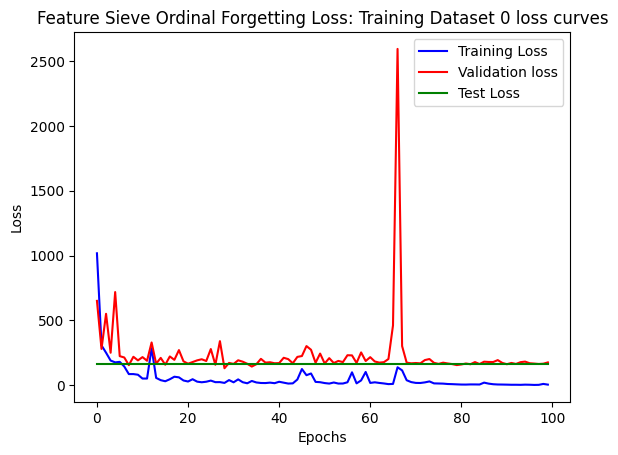

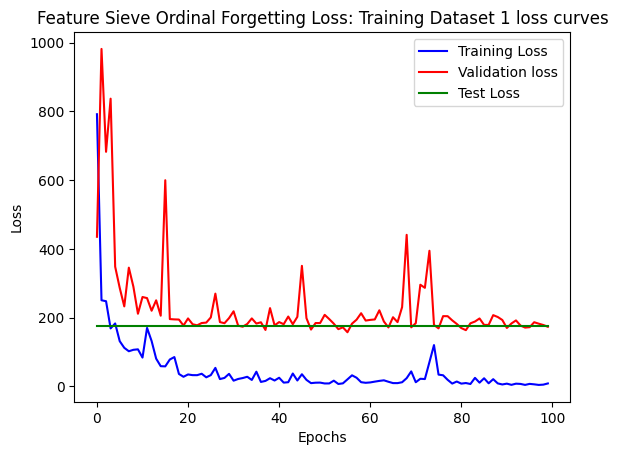

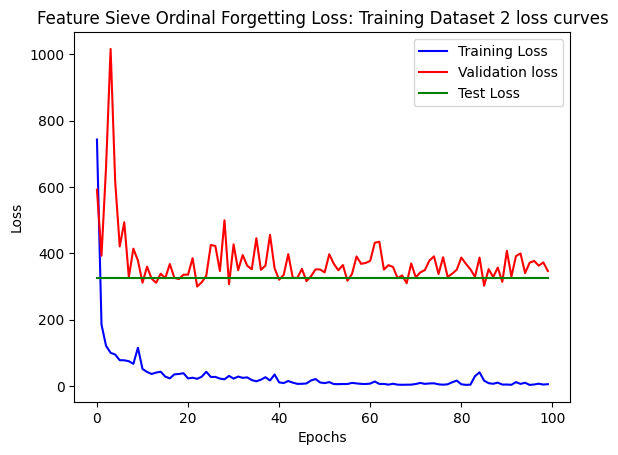

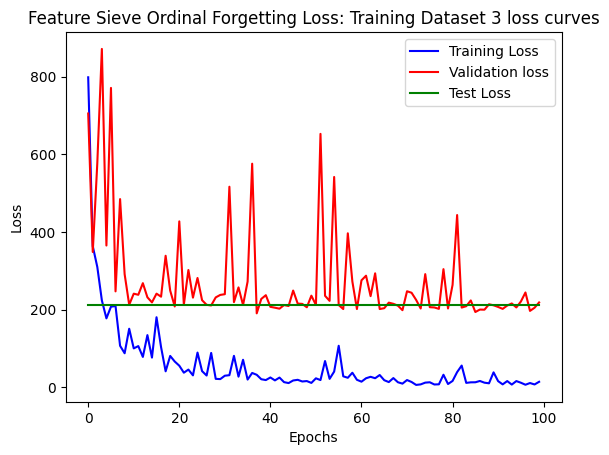

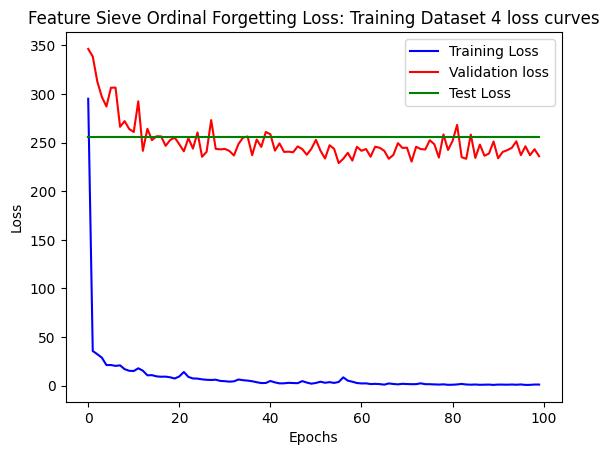

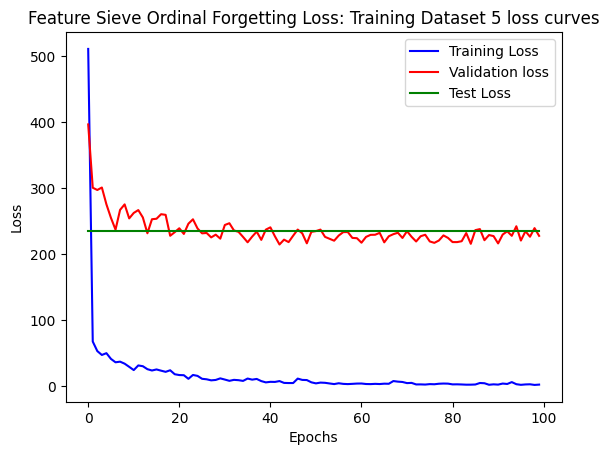

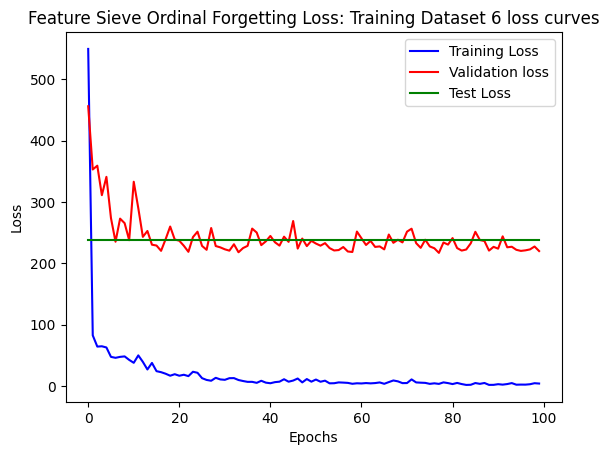

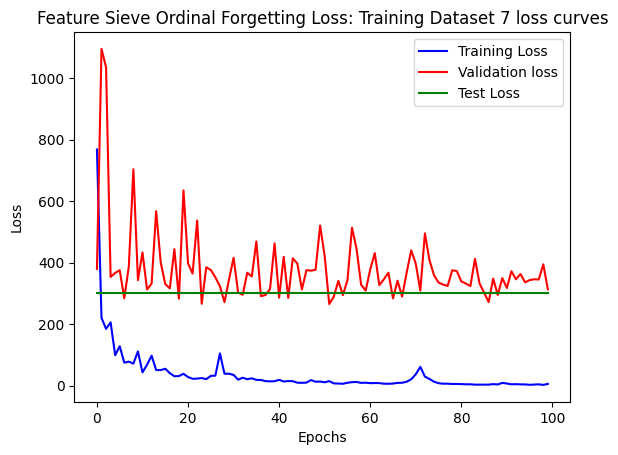

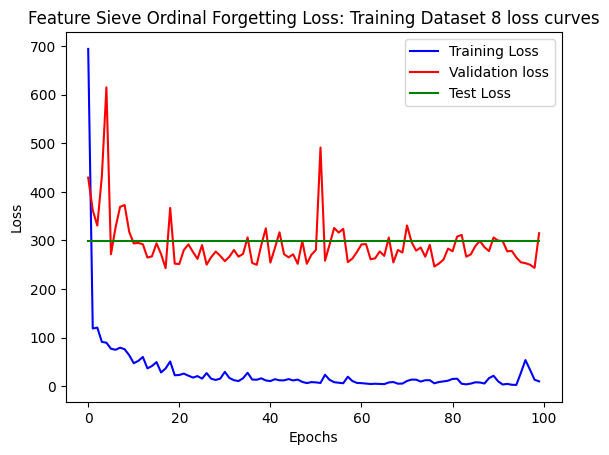

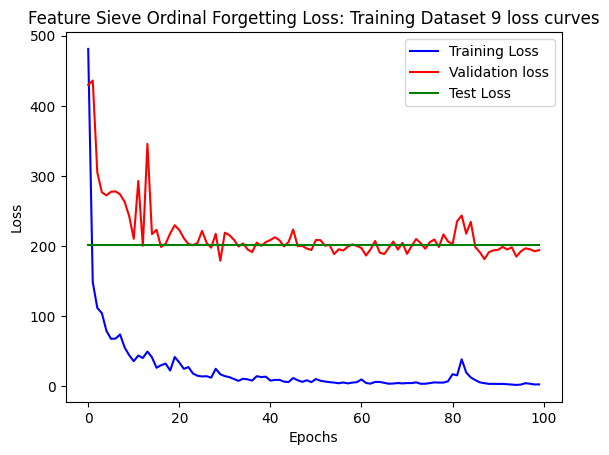

In [33]:
#plotting loss curves
for i in range(len(train_dataloaders)):
    plot_loss_curves(fs_ord_tlosses[i], fs_ord_vlosses[i], fs_ord_test_losses[i],  epochs=100, model_name = f"Feature Sieve Ordinal Forgetting Loss: Training Dataset {i}")

In [35]:
comp_fs_ord = fs_ord(1, best_num_bins, False).to(device)
comp_fs_ord, tloss, vloss = train_fs_ord(comp_fs_ord, comp_train_dataloader, val_dataloader, num_bins=best_num_bins, forget_iters=best_forget_iter, lrs=[0.0005, 0.0005, best_forget_lr], epochs=100, verbose=False)
comp_ord_tst_loss = eval_FSModel(comp_fs_ord, test_dataloader)

100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [1:54:15<00:00, 68.56s/it]


Test Loss: 63.51879119873047


NameError: name 'comp_ord_test_loss' is not defined

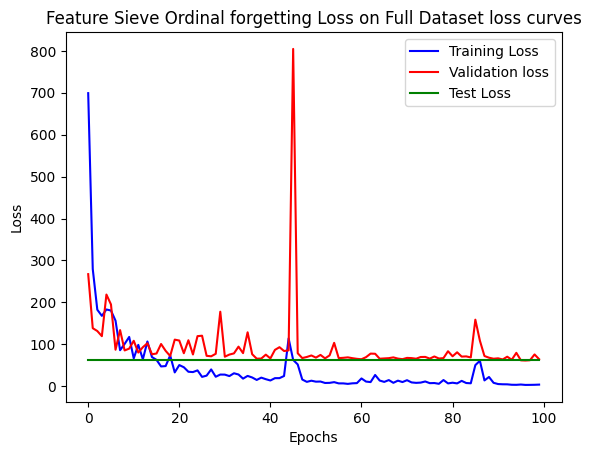

In [36]:
fs_ord_test_losses.insert(0, comp_ord_tst_loss)
plot_loss_curves(tloss, vloss, comp_ord_tst_loss, epochs=100, model_name="Feature Sieve Ordinal forgetting Loss on Full Dataset")

# Plotting a comparison between Models in different Datasets

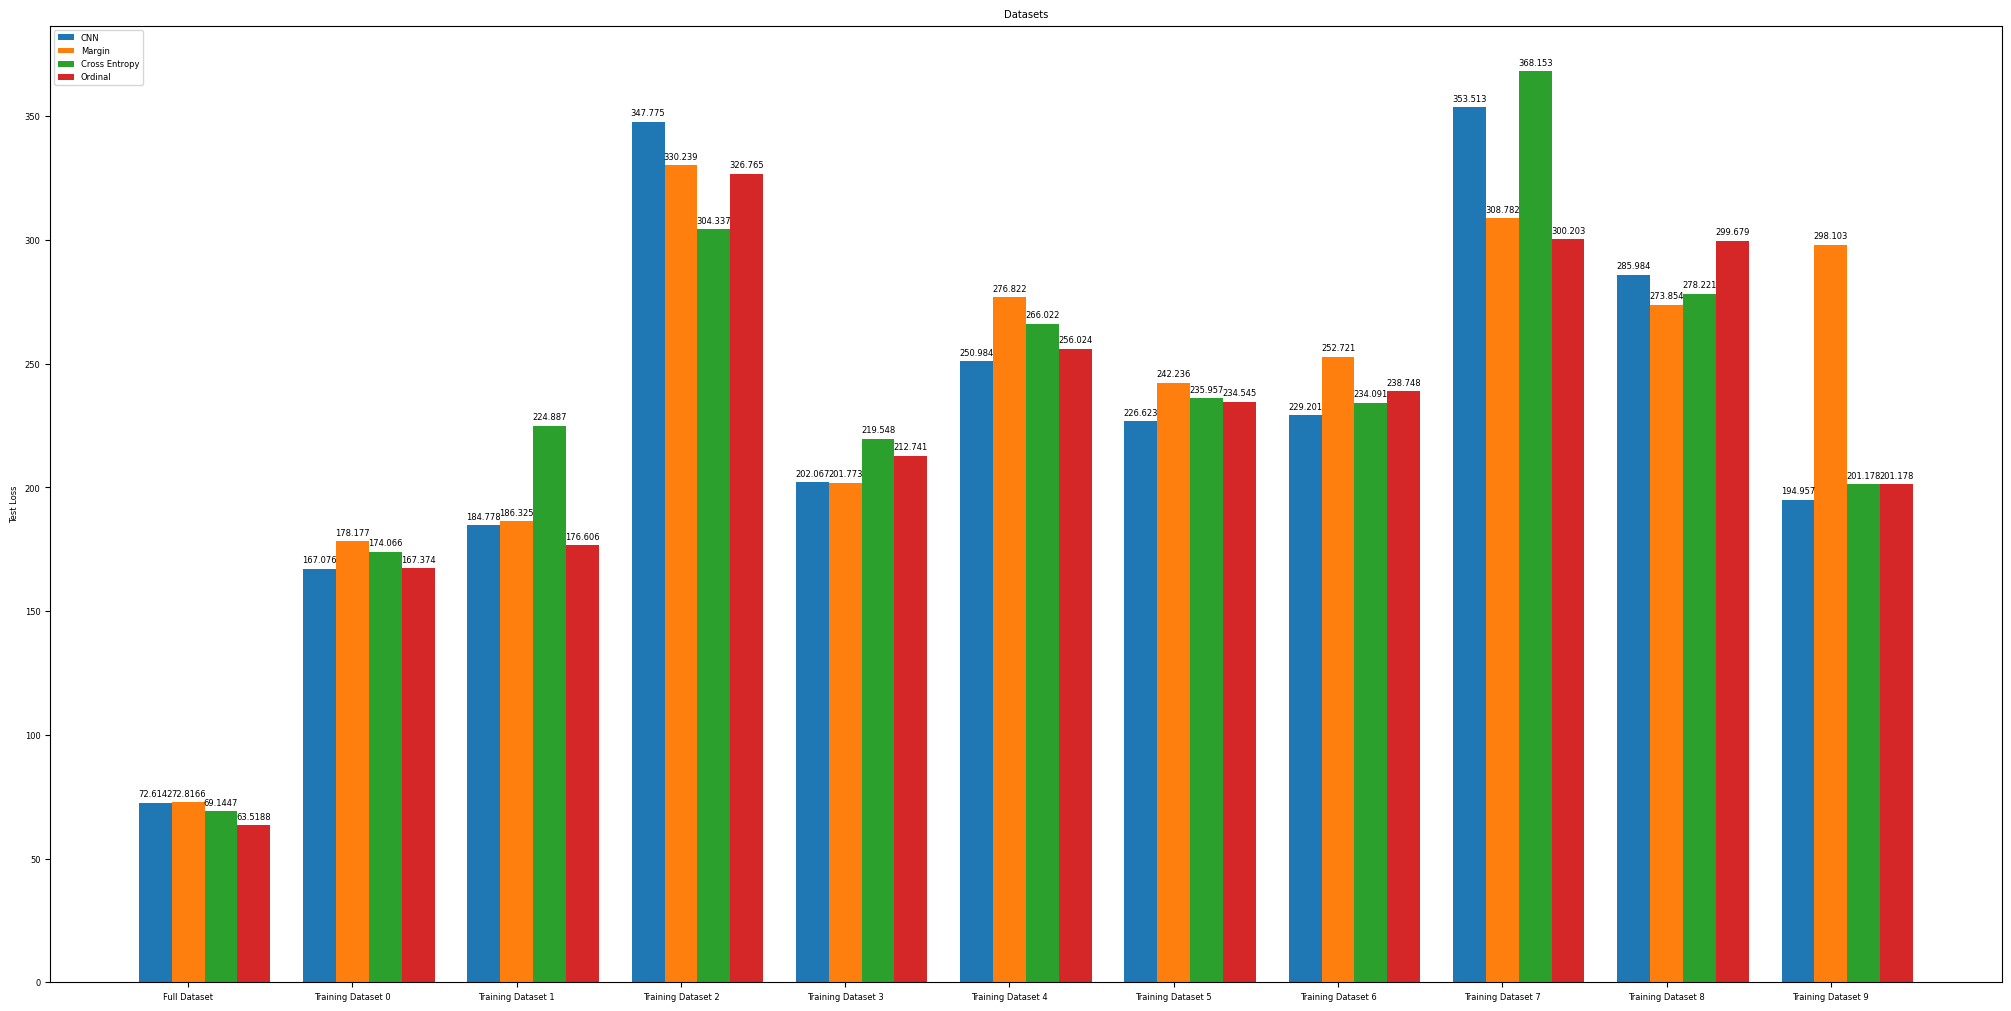

In [93]:
cnn_tst_loss = [72.61416625976562, 167.07644653320312, 184.7777862548828, 347.7750549316406, 202.0666046142578, 250.9844512939453, 226.62294006347656, 229.2008819580078, 353.51263427734375, 285.98394775390625, 194.95729064941406]
fs_tst_losses = [72.8166275024414, 178.17657470703125, 186.3246612548828, 330.2391052246094, 201.7730255126953, 276.8222351074219, 242.23550415039062, 252.7206573486328, 308.7821350097656, 273.854248046875, 298.1032409667969]
fs_ce_test_loss = [69.14472198486328,  174.06626892089844, 224.8866729736328, 304.33721923828125, 219.54811096191406, 266.0223388671875, 235.9572296142578, 234.09063720703125, 368.1534423828125, 278.2205810546875, 201.1782684326172]

plt.rcParams["figure.figsize"] = (20, 10)
plt.rcParams.update({"font.size":6})

datasets = [f"Training Dataset {i}" for i in range(10)]
datasets.insert(0, "Full Dataset")

test_losses = {
    "CNN": cnn_tst_loss,
    "Margin": fs_tst_losses,
    "Cross Entropy": fs_ce_test_loss,
    "Ordinal": fs_ord_test_losses
}

x = np.arange(len(cnn_tst_loss))
width = 0.2
multiplier = 0

fig, ax = plt.subplots(layout="constrained")

for model_type, test_loss in test_losses.items():
    offset = width*multiplier
    rects = ax.bar(x + offset, test_loss, width, label=model_type)
    ax.bar_label(rects, padding=3)
    multiplier += 1

ax.set_ylabel("Test Loss")
ax.set_title("Datasets")
ax.set_xticks(x+ width, datasets)
ax.legend(loc="upper left")

plt.savefig("Test_Losses.png")
plt.show()

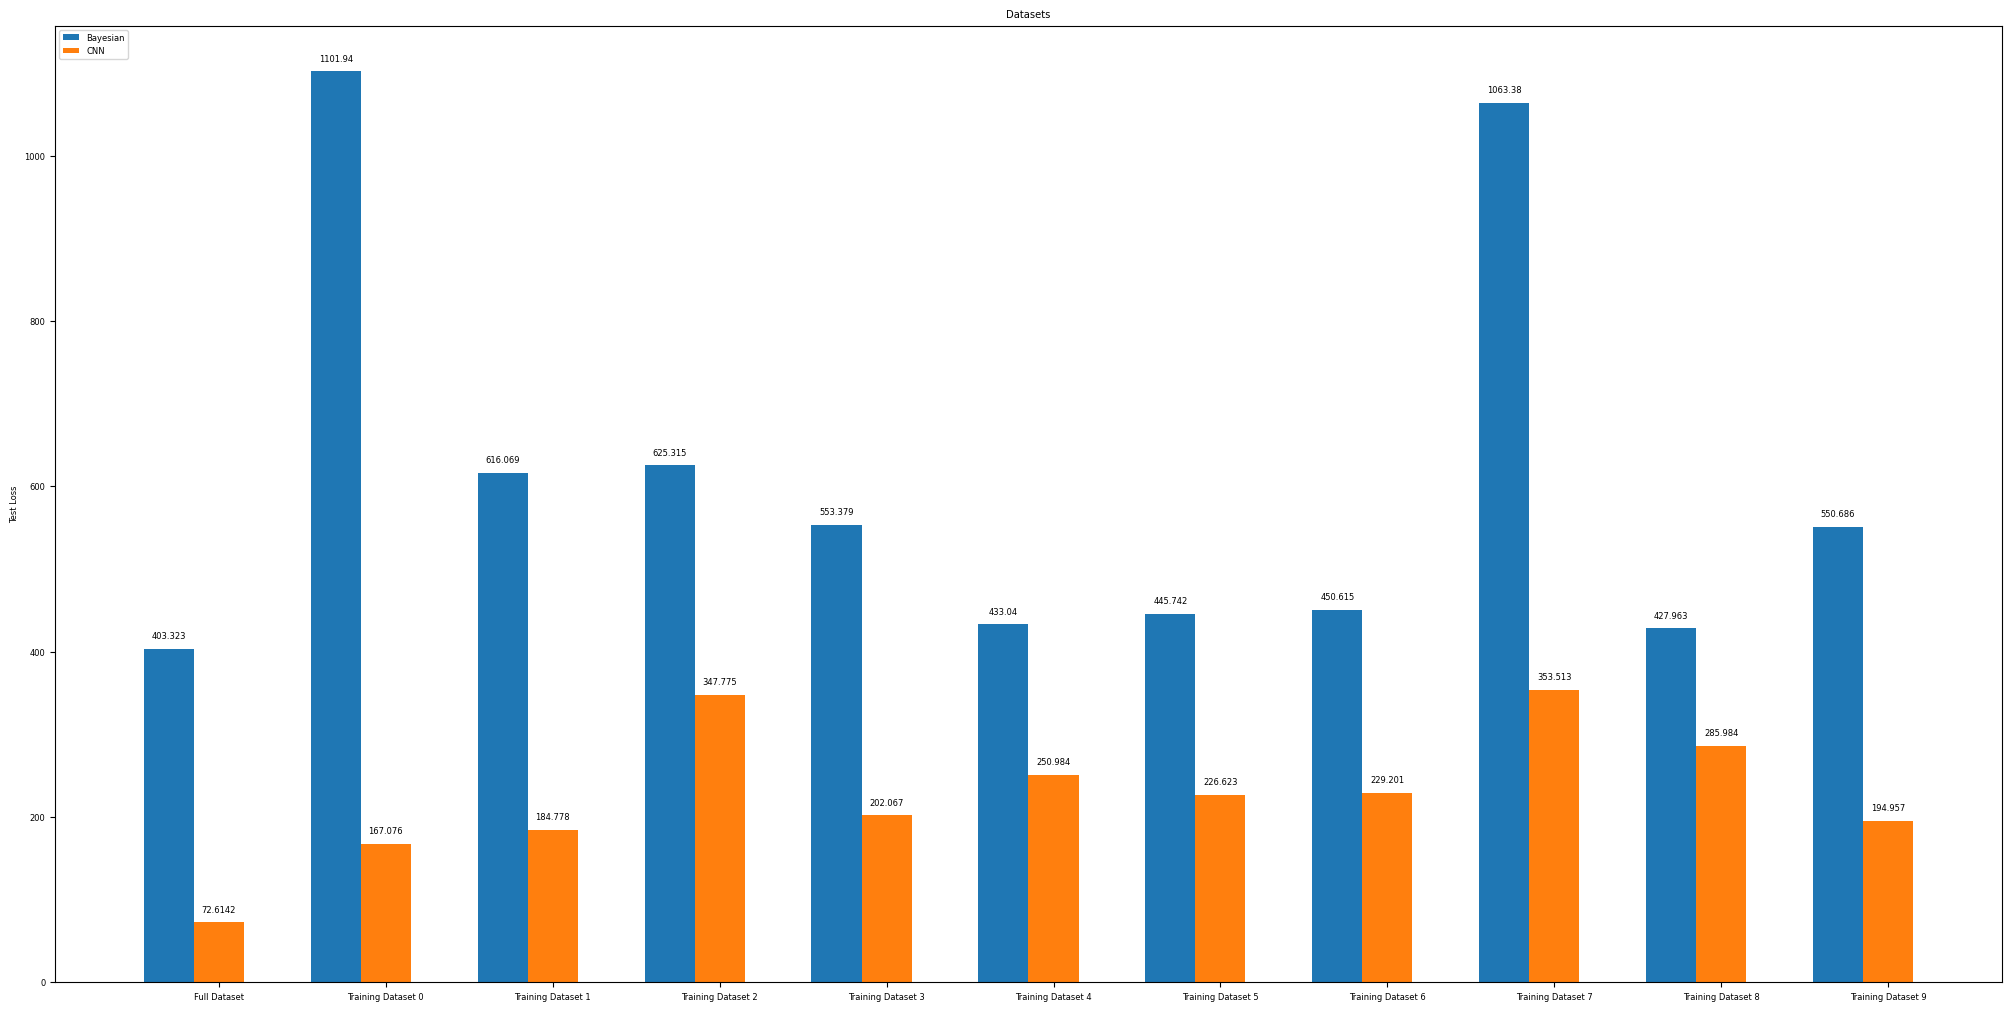

In [63]:
#plotting bayesian Losses
width = 0.3
multiplier = 0

test_losses = {
    "Bayesian": test_losses_bayesian,
    "CNN": cnn_tst_loss
}

fig, ax = plt.subplots(layout="constrained")

for model_type, test_loss in test_losses.items():
    offset = width*multiplier
    rects = ax.bar(x + offset, test_loss, width, label=model_type)
    ax.bar_label(rects, padding=6)
    multiplier += 1

ax.set_ylabel("Test Loss")
ax.set_title("Datasets")
ax.set_xticks(x+ width, datasets)
ax.legend(loc="upper left")

plt.savefig("Test_Losses_Bayesian.png")
plt.show()

# Plotting the Bias of different datasets

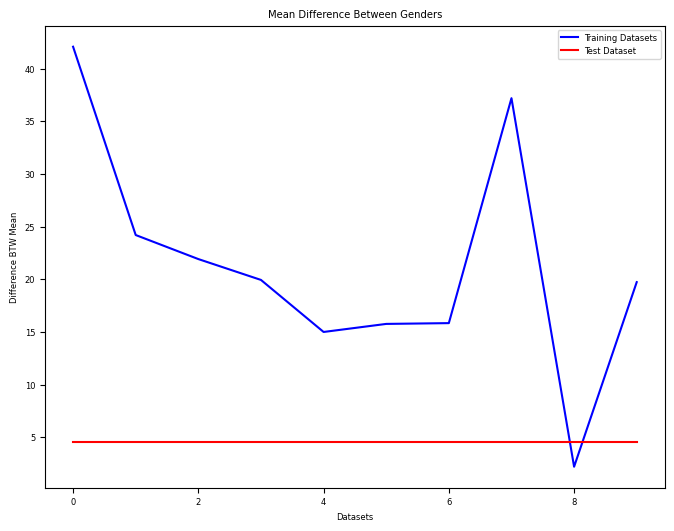

In [71]:
diff_mean = []
plt.rcParams["figure.figsize"] = (8.0, 6.0)
plt.rcParams.update({"font.size": 6.0})

for i in range(len(dfs_gen2)):
    df = dfs_gen2[i]
    male_df = df[df.gender == 0].reset_index(drop = True)
    female_df = df[df.gender == 1].reset_index(drop= True)

    male_mean = male_df.age.mean()
    female_mean = female_df.age.mean()

    diff_mean.append(np.abs(male_mean - female_mean))

male_mean = test_df[test_df.gender == 0].age.mean()
female_mean = test_df[test_df.gender == 1].age.mean()
test_diff_mean = np.abs(male_mean - female_mean)

male_mean = val_df[val_df.gender  == 0].age.mean()
feamle_mean = val_df[val_df.gender == 1].age.mean()
val_diff_mean = np.abs(male_mean - female_mean)

plt.plot(range(len(diff_mean)), diff_mean, color = 'blue', label = "Training Datasets")
plt.plot(range(len(diff_mean)), [test_diff_mean] * len(diff_mean), color = 'red', label = "Test Dataset")
plt.xlabel("Datasets")
plt.ylabel("Difference BTW Mean")
plt.title("Mean Difference Between Genders")
plt.legend()
plt.savefig("Difference in Means.png")
plt.show()

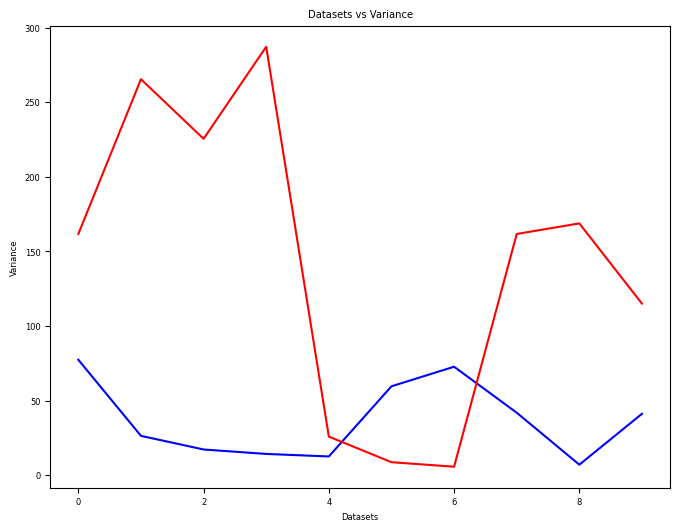

In [72]:
male_var = []
female_var = []

for i in range(len(dfs_gen2)):
    df = dfs_gen2[i]
    male_v = df[df.gender ==0].age.var()
    female_v = df[df.gender ==1].age.var()

    male_var.append(male_v)
    female_var.append(female_v)

test_male_var = test_df[test_df.gender ==0].age.var()
test_female_var = test_df[test_df.gender ==1].age.var()

val_male_df = test_df[test_df.gender ==0].age.var()
val_female_df = test_df[test_df.gender == 1].age.var()

plt.plot(range(len(male_var)), male_var, color  = "blue", label = "Male Variance")
plt.plot(range(len(female_var)), female_var, color = "red", label = "Female Variance")
plt.xlabel("Datasets")
plt.ylabel("Variance")
plt.title("Datasets vs Variance")
plt.savefig("Variance of Genders.png")
plt.show ()

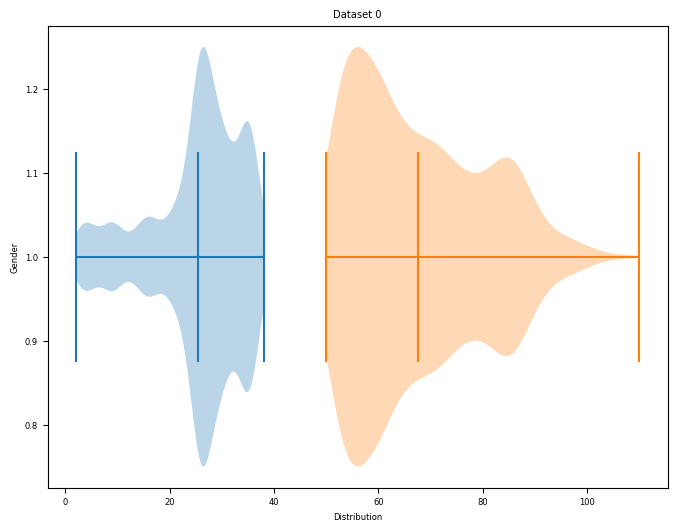

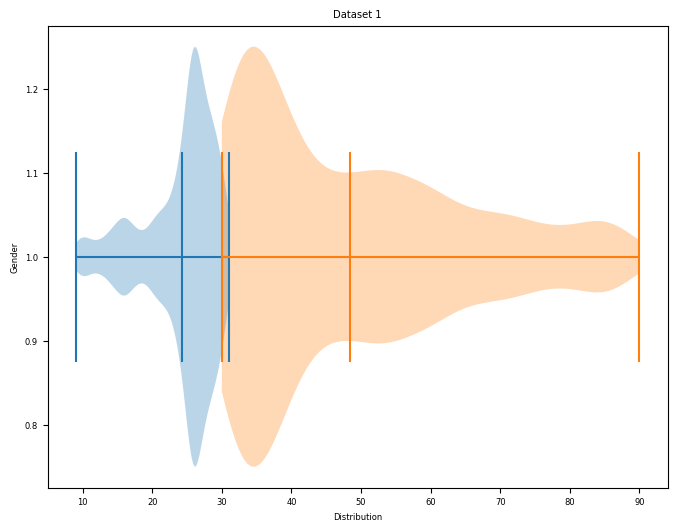

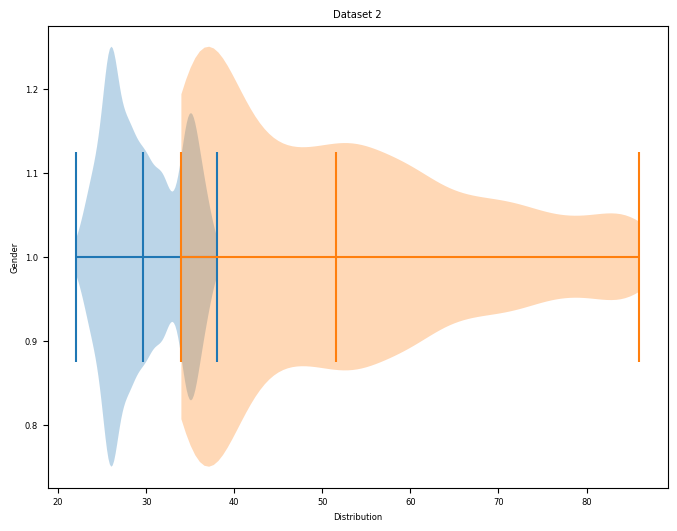

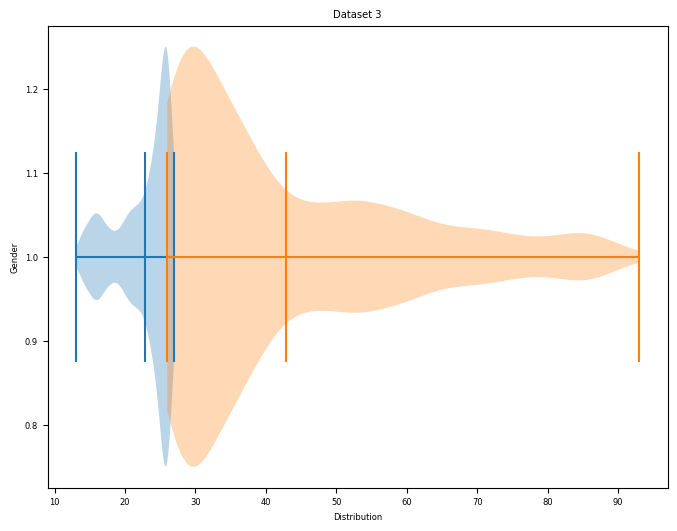

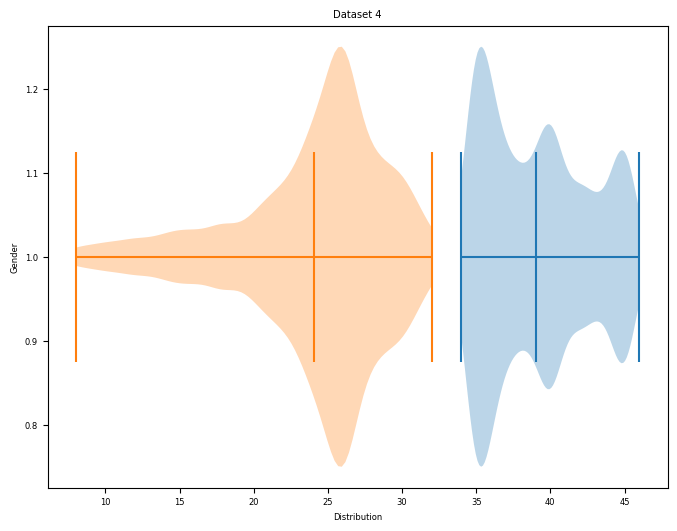

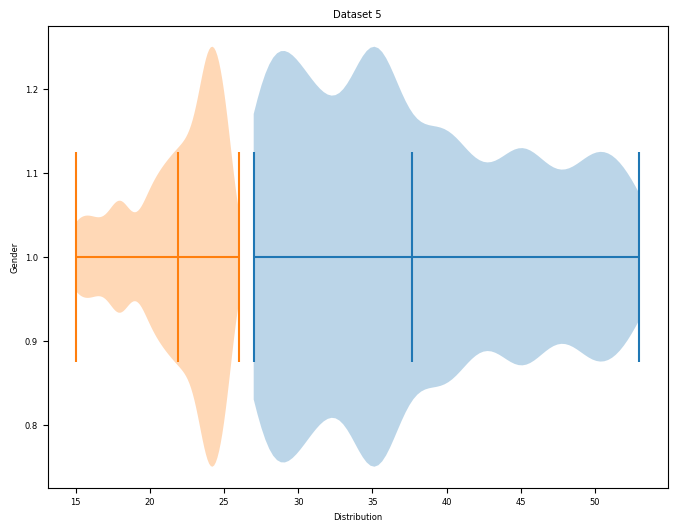

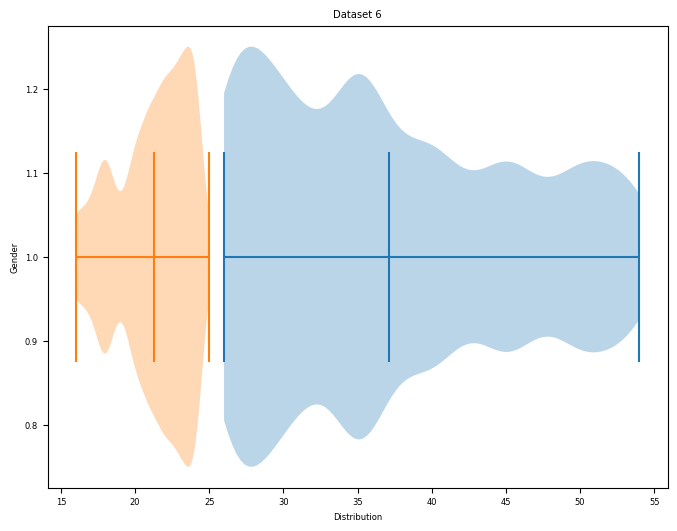

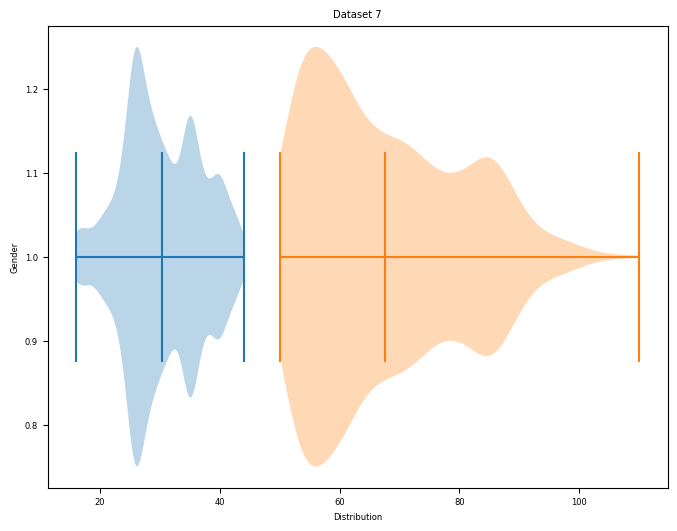

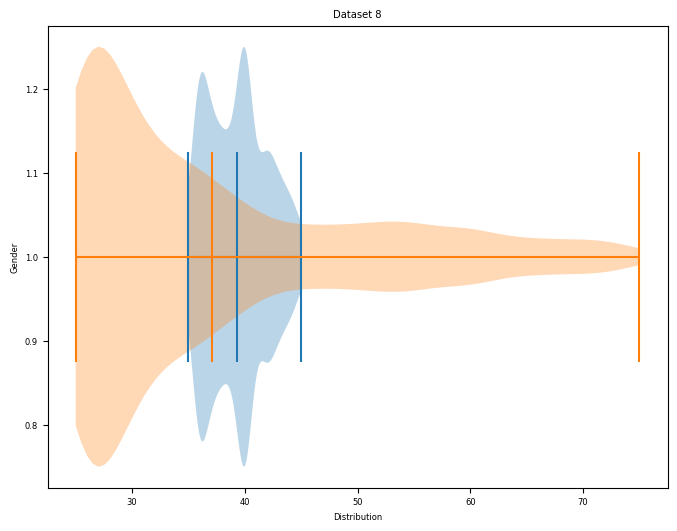

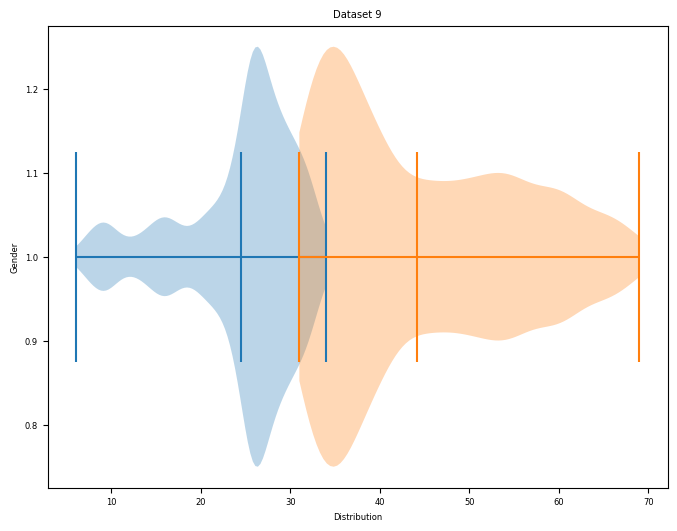

In [88]:
for i in range(len(dfs_gen2)):
    df = dfs_gen2[i]
    male_df = df[df.gender == 0].reset_index(drop = True)
    female_df = df[df.gender == 1].reset_index(drop = True)
    
    plt.violinplot(male_df.age, vert = False, showmeans = True)
    plt.violinplot(female_df.age, vert = False, showmeans = True)
    plt.xlabel("Distribution")
    plt.ylabel("Gender")
    plt.title(f"Dataset {i}")
    plt.savefig(f"./Datasets/dataset_dist{i}.png")
    plt.show()

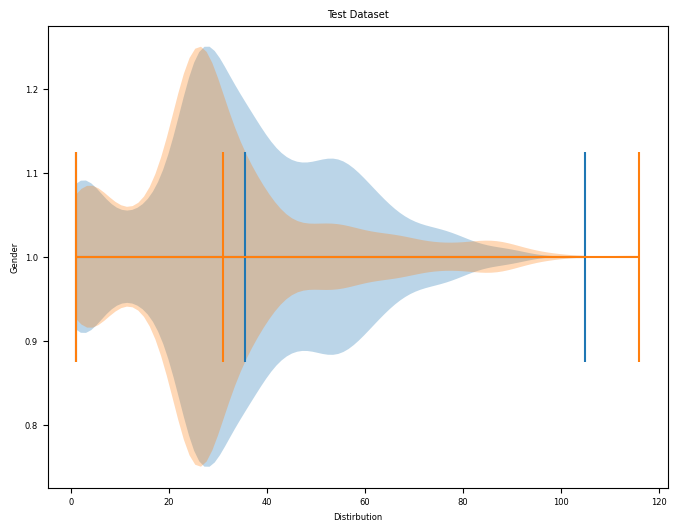

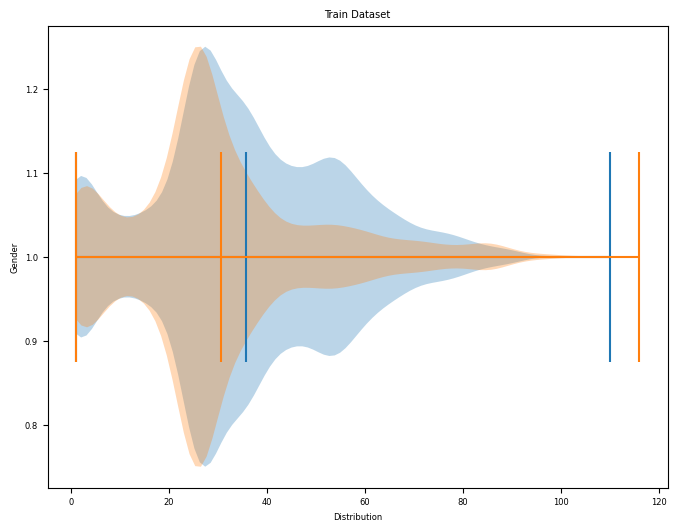

In [89]:
#Plotting distribution of test dataset
male_test_df = test_df[test_df.gender == 0].age.values
female_test_df = test_df[test_df.gender == 1].age.values
plt.violinplot(male_test_df, vert = False, showmeans = True)
plt.violinplot(female_test_df, vert = False, showmeans = True)
plt.xlabel("Distirbution")
plt.ylabel("Gender")
plt.title("Test Dataset")
plt.savefig("test_df.png")
plt.show()

male_train_df = train_df[train_df.gender == 0].age.values
female_train_df = train_df[train_df.gender == 1].age.values
plt.violinplot(male_train_df, vert=False, showmeans = True)
plt.violinplot(female_train_df, vert = False, showmeans= True)
plt.xlabel("Distribution")
plt.ylabel("Gender")
plt.title("Train Dataset")
plt.savefig("train_df.png")
plt.show()